Status: complete

Notes
- The reads analyzed here (from a 2024-07-09 sequencing run) are of the same library as sequenced on 2024-06-20, albeit with different read lengths. The previous sequencing run was analyzed in the 20240620.ipynb notebook. As expected, the analysis here of the newer reads yields nearly identical results.
- The higher sequencing read quality of this second run is noticeable and reflected in both higher barcode identification rate (although this is conflated by read lengths) and lower proportion mismatch in detected UMI sequence between read 1 and read 2 (~3% in 2024-06-20 sequencing run, and ~1.5% in this sequencing run).
- I skipped the section "Check structure of unassigned reads" in this notebook relative to the 20240620.ipynb notebook.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark

In [2]:
# Python Standard Library modules
import collections
import functools
import gzip
import itertools
import os
import re
import subprocess
import sys

# Basic SciPy packages
import numpy as np
import scipy
import pandas as pd

# Visualization packages
import matplotlib.collections
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import plotly.graph_objects as go
import plotly.express as px

from tqdm.auto import tqdm
import IPython.display

# Custom modules
sys.path.append('../scripts')
import string_distances
import parse_barcodes
from helpers import fastq_parse

In [3]:
%watermark
%watermark --conda
%watermark --iversions

Last updated: 2024-07-13T18:43:10.485464-07:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.14.0-362.24.1.el9_3.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 128
Architecture: 64bit

conda environment: py3

plotly    : 5.15.0
numpy     : 1.26.4
matplotlib: 3.9.0
pandas    : 2.2.1
seaborn   : 0.13.2
sys       : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
IPython   : 8.14.0
re        : 2.2.1
scipy     : 1.14.0



In [4]:
%%bash
splitcode --version

splitcode, version 0.30.0


In [5]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20240709')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20240709')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20240709')
DIR_RESULTS = os.path.join(DIR_PROJECT, 'results', '20240709')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)

# Constants and Helpers

In [6]:
ROUNDS = ['R5', 'R6', 'R7', 'R8']

In [7]:
reprocess = True

Note: The current method of library complexity estimation assumes that the number of available UMIs far exceeds the number of unique molecules, and therefore underestimates the true library complexity. A better model would account for the possibility of real UMI collisions, and as a consequence of PCR duplicates/sequencing.

In [8]:
def estimate_library_complexity(count_total, count_dedup, ub=None, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md

    Generative model: Poisson sampling (i.e., with replacement) count_total reads from
    M unique molecules, such that count_dedup molecules were sampled at least once. Solve
    for M.
    '''
    if ub is None:
        ub = count_total*1e5
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: (M * (1 - np.exp(-count_total/M)) - count_dedup)**2,
      bracket=(count_dedup, ub)
    )
    assert res.fun < max_err
    return res.x

def estimate_library_complexity2(count_total, count_mean, ub=None, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md

    Generative model: Poisson sampling (i.e., with replacement) count_total reads from
    M unique molecules, yielding mean observed counts count_mean. Solve for M.
    '''
    ub = ub if ub is not None else count_total*1e5
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: ((count_total / M) / (1 - np.exp(-count_total / M)) - count_mean)**2,
      bracket=(count_total / count_mean, ub)
    )
    assert res.fun < max_err
    return res.x

# Data

- [Library Sheet](https://docs.google.com/spreadsheets/d/1tHDx2zHjpgJU_fhisOwxBgzmDJkgLak7ENZBTGa7SUA)
- [Enhanced Sample Sheet](https://docs.google.com/spreadsheets/d/1gatGQhfVA3Z2OSdXc8PIgn6hZLAAdQwd00LpMmzwJ-o)
- [Benchling notebook: 2024-06-05 Tag Plate Contamination, v5](https://benchling.com/s/etr-TNItjIfghI4tB82pYBOA)

In [9]:
path_df_data = os.path.join(DIR_RESULTS, 'sample_info.csv')
if not os.path.exists(path_df_data) or reprocess:
    regex_fastq_files = re.compile((
        r'(?P<filename>SPRITE_Zero_R5-R8_tags_index(?P<sample>[0-9]+)_R(?P<read>1|2).fastq.gz)'))
    
    files_fastq = sorted([file for file in os.listdir(DIR_DATA) if file.endswith('.fastq.gz')])
    df_data = pd.DataFrame([
        regex_fastq_files.match(file).groupdict() for file in files_fastq]) \
        .astype(dict(read=int, sample=int))
    
    popen_counts = dict()
    for (sample, read), group in df_data.groupby(['sample', 'read']):
        filename = group['filename'].item()
        cmd = "unpigz -c {path_fastq_raw} | wc -l | awk '{{print $1 / 4}}'".format(path_fastq_raw=os.path.join(DIR_DATA, filename))
        popen_counts[(sample, read)] = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    
    df_data['n_reads'] = int(0)
    for (sample, read), popen in popen_counts.items():
        count, err = popen.communicate()
        assert err is None and popen.returncode == 0
        df_data.loc[(df_data['sample'] == sample) & (df_data['read'] == read), 'n_reads'] = int(count.decode().strip())

    assert (df_data.groupby('sample')['n_reads'].unique().map(len) == 1).all()

    # from the library sheet, linked above
    path_library_info = os.path.join(DIR_AUX, 'SPRITE Zero R5-R8 Tag Contamination Libraries.tsv')
    df_library_info = (
        pd.read_csv(
            path_library_info,
            sep='\t',
            header=0,
            usecols=['Sample', 'Estimated complexity']
        )
        .dropna(subset='Estimated complexity')
        .rename(columns={'Sample': 'sample', 'Estimated complexity': 'Complexity (Tapestation)'})
    )
    df_library_info = df_library_info.loc[df_library_info['sample'] != '10, pooled ligation'].copy()
    df_library_info.loc[df_library_info['sample'] == '10, sequential ligation', 'sample'] = '10'
    df_library_info = df_library_info.astype({'sample': int})

    df_data = (
        df_data
        .merge(df_library_info, how="left")
        .sort_values(['sample', 'read'])
        .reset_index(drop=True)
    )
    df_data.to_csv(path_df_data, index=False)
else:
    df_data = pd.read_csv(path_df_data, index_col=False)

In [10]:
print('Total number of paired reads:', df_data['n_reads'].sum() // 2)
display(df_data)

Total number of paired reads: 742547


filename  sample  read  n_reads  \
0    SPRITE_Zero_R5-R8_tags_index1_R1.fastq.gz       1     1    58824   
1    SPRITE_Zero_R5-R8_tags_index1_R2.fastq.gz       1     2    58824   
2    SPRITE_Zero_R5-R8_tags_index2_R1.fastq.gz       2     1    79110   
3    SPRITE_Zero_R5-R8_tags_index2_R2.fastq.gz       2     2    79110   
4    SPRITE_Zero_R5-R8_tags_index3_R1.fastq.gz       3     1    81375   
5    SPRITE_Zero_R5-R8_tags_index3_R2.fastq.gz       3     2    81375   
6    SPRITE_Zero_R5-R8_tags_index4_R1.fastq.gz       4     1    64149   
7    SPRITE_Zero_R5-R8_tags_index4_R2.fastq.gz       4     2    64149   
8    SPRITE_Zero_R5-R8_tags_index5_R1.fastq.gz       5     1    65088   
9    SPRITE_Zero_R5-R8_tags_index5_R2.fastq.gz       5     2    65088   
10   SPRITE_Zero_R5-R8_tags_index6_R1.fastq.gz       6     1    72189   
11   SPRITE_Zero_R5-R8_tags_index6_R2.fastq.gz       6     2    72189   
12   SPRITE_Zero_R5-R8_tags_index7_R1.fastq.gz       7     1    43775   
13   SPRITE_Zero_R5-R8_tags_index7_R2.fastq.gz       7     2    43775   
14   SPRITE_Zero_R5-R8_tags_index8_R1.fastq.gz       8     1    36559   
15   SPRITE_Zero_R5-R8_tags_index8_R2.fastq.gz       8     2    36559   
16   SPRITE_Zero_R5-R8_tags_index9_R1.fastq.gz       9     1    64018   
17   SPRITE_Zero_R5-R8_tags_index9_R2.fastq.gz       9     2    64018   
18  SPRITE_Zero_R5-R8_tags_index10_R1.fastq.gz      10     1    48183   
19  SPRITE_Zero_R5-R8_tags_index10_R2.fastq.gz      10     2    48183   
20  SPRITE_Zero_R5-R8_tags_index11_R1.fastq.gz      11     1    64377   
21  SPRITE_Zero_R5-R8_tags_index11_R2.fastq.gz      11     2    64377   
22  SPRITE_Zero_R5-R8_tags_index12_R1.fastq.gz      12     1    64900   
23  SPRITE_Zero_R5-R8_tags_index12_R2.fastq.gz      12     2    64900   

    Complexity (Tapestation)  
0               8.825994e+08  
1               8.825994e+08  
2               1.213809e+09  
3               1.213809e+09  
4               1.326722e+09  
5               1.326722e+09  
6               1.223219e+09  
7               1.223219e+09  
8               1.204400e+09  
9               1.204400e+09  
10              1.458453e+09  
11              1.458453e+09  
12              9.503469e+08  
13              9.503469e+08  
14              8.459028e+08  
15              8.459028e+08  
16              1.194991e+09  
17              1.194991e+09  
18              8.026197e+08  
19              8.026197e+08  
20              1.072669e+09  
21              1.072669e+09  
22              1.279675e+09  
23              1.279675e+09

# FastQC

Expectations
- Read 1: good sequence diversity due to UMIs on the oligo
  - No adapter content expected, since expected insert length is identical to the read 1 length of 120 bp.
- Read 2: near total duplication from each sample, since all barcodes from the same well should have the same R5, R6, R7, and R8 tags
  - Adapter content expected at 121-125 bp, since read length of 180 bp exceeds expected insert length of 120-122 bp.

Gross observations: matches expectations

In [11]:
%%bash -s {DIR_DATA} {DIR_PROC}
DIR_DATA="$1"
DIR_PROC="$2"
source ~/.bashrc
DIR_FASTQC_OUT="$DIR_PROC/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ]; then
    mkdir "$DIR_PROC/fastqc"
    cd "$DIR_DATA"
    conda activate chipdip
    fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"
fi

# Count barcodes

Expected read structures
- Benchling DNA sequence: [Oligo (PC50_12merUMI) + R4_Odd_1 + R5 + R6 + R7 + R8 PCR Product (2Puni + 2Pbc)](https://benchling.com/s/seq-fxCIkxFQXwcM3kriRxri)
- Splitcode config Google Sheet: https://docs.google.com/spreadsheets/d/17oQwNaN5bmakwODHROgNKeMO11Nj3eM_HrayYwVDPIQ
  - Sheet `expected_structure`: used here to identify full, expected barcodes
  - Other sheets: used later for troubleshooting barcode identification for unassigned reads.

| Component                                 | Length | R1 coordinates | R2 coordinates  |
| ----------------------------------------- | ------ | -------------- | --------------- |
| 2Puni adapter, Illumina universal adapter | 11     | n/a            | 120-124:131-135 |
| Oligo UMI                                 | 12     | 0:12           | 108-111:120-124 |
| LigEven / Even overhang                   | 7      | 12:19          | 101-105:108-111 |
| Odd1                                      | 17     | 19:36          | 84-88:101-105   |
| LigR4 / R4 overhang                       | 7      | 36:43          | 77-81:84-88     |
| R5 unique sequence                        | 16     | 43:59          | 61-65:77-81     |
| LigR5 / R5 overhang                       | 7      | 59:66          | 54-58:61-65     |
| R6 unique sequence                        | 16     | 66:82          | 38-42:54-58     |
| LigR6 / R6 overhang                       | 7      | 82:89          | 31-35:38-42     |
| R7 unique sequence                        | 16     | 89:105         | 15-19:31-35     |
| LigR7 / R7 overhang                       | 7      | 105:112        | 8-12:15-19      |
| R8 unique sequence                        | 8-12   | 112:120-124    | 0:8-12          |
| 2Pbc adapter, Illumina universal adapter  | 11     | n/a (exceeds read length)        | n/a            |

1. Add barcode and UMI to read name:

   `@read::[LigEven][OddTop_1][LigR4][R5Top_<R5_1>][LigR5][R6Top_<R6_1>][LigR6][R7Top_<R7_1>][LigR7][R8StgTop_<R8_1>][R8StgBot_<R8_2>][R7][R7Bot_<R7_2>][R6][R6Bot_<R6_2>][R5][R5Bot_<R5_2>][R4][OddBot_1][Even][2Puni][2Puni_2] RX:Z:<umi1>-<umi2>`


2. Calculate barcode counts

## Tag identification by splitcode

In [12]:
path_config = os.path.join(DIR_AUX, 'splitcode_config.tsv')

In [13]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_PROJECT} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_PROJECT="$3"
PATH_CONFIG="$4"

PATH_SBATCH="$DIR_PROJECT/scripts/splitcode2.sbatch"

for PATH_R1 in "$DIR_DATA"/*_R1.fastq.gz; do
    SAMPLE="$(echo "$PATH_R1" | grep -o -E -e 'index[0-9]+' | sed -e 's/index//')"
    PATH_R2="$(ls "${DIR_DATA}/SPRITE_Zero_R5-R8_tags_index${SAMPLE}"_R2.fastq.gz)"
    PATH_MAPPING="$DIR_PROC/mapping-${SAMPLE}.tsv"
    PATH_SUMMARY="$DIR_PROC/summary-${SAMPLE}.json"
    PATH_OUTPUT="$DIR_PROC/read_barcodes-${SAMPLE}.txt.gz"

    if [ ! -f "$PATH_OUTPUT" ]; then

        # submit as SLURM jobs
        PATH_SBATCH_ERROR="$DIR_PROC/sbatch-${SAMPLE}.err"
        PATH_SBATCH_OUT="$DIR_PROC/sbatch-${SAMPLE}.out"
        sbatch --error="$PATH_SBATCH_ERROR" --out="$PATH_SBATCH_OUT" \
            "$PATH_SBATCH" \
            "$PATH_CONFIG" "$PATH_MAPPING" "$PATH_SUMMARY" "$PATH_OUTPUT" "$PATH_R1" "$PATH_R2"

        # run locally
        # splitcode -c "$PATH_CONFIG" \
        #     --nFastqs=2 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta -t 8 \
        #     --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" --output=/dev/stdout,/dev/null \
        #     "$PATH_R1" "$PATH_R2" |
        # awk '$1 ~ /^>/' |
        # pigz -p 8 > "$PATH_OUTPUT"
    fi
done

## Compare with exact matching

In [14]:
dict_complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
def reverse_complement(s, allow_noncanonical=False):
    if allow_noncanonical is False:
        return ''.join(dict_complement[base] for base in reversed(s))
    else:
        return ''.join(dict_complement.get(base, base) for base in reversed(s))

In [15]:
read1_structure = (
    ('umi', 12),
    ('ids', 'LigEven'),
    ('ids', 'OddTop_1'),
    ('ids', 'LigR4'),
    ('groups', 'R5Top'),
    ('ids', 'LigR5'),
    ('groups', 'R6Top')
)

read2_structure = (
    ('groups', 'R8StgBot'),
    ('ids', 'R7'),
    ('groups', 'R7Bot'),
    ('ids', 'R6'),
    ('groups', 'R6Bot'),
    ('ids', 'R5'),
    ('groups', 'R5Bot'),
    ('ids', 'R4'),
    ('ids', 'OddBot_1'),
    ('ids', 'Even'),
    ('umi', 12),
    ('ids', '2Puni'),
    ('ids', '2Puni_2')
)

In [16]:
def structure_to_regex(structure, config):
    '''
    Convert a specified read structure into a regular expression 

    Args
    - structure: sequence of 2-tuple
        Sequence of (part, name or #), in order that the parts appear in the read
        - part: one of 'umi', 'ids', or 'groups'
          - 'umi': # gives the length of the UMI in bp
          - 'ids': the name is name of a particular tag in `config`
          - 'groups': the name is the name of a group of tags in `config`
    - config: pandas.DataFrame
        Barcode config table, following splitcode's format. Must have the columns groups, ids, and tags.

    Returns
    - pattern: re.Pattern
        Regular expression
    - group_tag_to_id: dict(str -> dict(str -> str))
        Map from tag group name to a map from sequence to tag name
    '''
    group_tag_to_id = dict()
    pattern = '^'
    for part, name in structure:
        if part == 'umi':
            pattern += f'(?P<umi>[ATCGN]{{{name}}})'
        elif part == 'ids':
            tags = config.loc[config['ids'] == name, 'tags']
            pattern += f'({"|".join(tags)})'
        elif part == 'groups':
            tags = config.loc[config['groups'] == name, ['tags', 'ids']].drop_duplicates().set_index('tags').squeeze(axis=1)
            assert tags.index.is_unique
            pattern += f'(?P<__group__{name}>' + '|'.join(tags.index) + ')'
            group_tag_to_id[name] = tags.to_dict()
        else:
            raise ValueError
    return re.compile(pattern), group_tag_to_id

In [17]:
def tag_id_exact(seq, structure, pattern, group_tag_to_id):
    '''
    Identify tags in a string sequence using regular expression matching.

    Args
    - seq: str
        Query sequence within which to match barcode
    - structure: sequence of 2-tuple
        Sequence of (part, name or #), in order that the parts appear in the read
        - part: one of 'umi', 'ids', or 'groups'
          - 'umi': # gives the length of the UMI in bp
          - 'ids': the name is name of a particular tag in `config`
          - 'groups': the name is the name of a group of tags in `config`
    - pattern: re.Pattern
        Regular expression pattern of target sequence
    - group_tag_to_id: dict(str -> dict(str -> str))
        Map from tag group name to a map from sequence to tag name

    Returns: 2-tuple or None (if no match)
    - barcode: str
        List of matched barcode tags, in order
    - umi: str
        Matched UMI sequence
    '''
    match = pattern.search(seq)
    if not match:
        return None
    match = match.groupdict()
    barcode = []
    for part, name in structure:
        if part == 'ids':
            barcode.append(name)
        elif part == 'groups':
            barcode.append(group_tag_to_id[name][match[f'__group__{name}']])
    return barcode, match['umi']

def paired_tag_extract(seq1, structure1, pattern1, group_tag_to_id1,
                       seq2, structure2, pattern2, group_tag_to_id2):
    '''
    Identify tags in a read pair using regular expression matching.

    Args: see tag_id_exact()

    Returns: str or None
    - If either read in the read pair does not match their corresponding
      pattern, returns None.
    - If both reads in the read pair are matched by their corresponding
      regular expression, then return a barcode string in the format
      '[tag1][tag2]... RX:Z:[umi1]-[reverse_complement(umi2)]'
      where the string of tags is in the order of tags in read 1 followed
      by those in read 2.
    '''
    result1 = tag_id_exact(seq1, structure1, pattern1, group_tag_to_id1)
    if result1 is None:
        return None
    barcode1, umi1 = result1
    result2 = tag_id_exact(seq2, structure2, pattern2, group_tag_to_id2)
    if result2 is None:
        return None
    barcode2, umi2 = result2
    return ''.join((f'[{name}]' for name in barcode1 + barcode2)) + f' RX:Z:{umi1}-{reverse_complement(umi2)}'

In [18]:
# read config file into pandas DataFrame
# - seek to first line after lines starting with '@' or '#'; 
#     pd.read_csv() only supports a single character comment
# - need to open file as binary to enable f.tell() to work
with open(path_config, 'rb') as f:
    pos = f.tell()
    for line in f:
        line = line.decode().strip()
        if line.startswith('#') or line.startswith('@') or line == '':
            pos = f.tell()
            continue
        f.seek(pos)
        break
    df_config = pd.read_csv(f, sep='\t')

In [19]:
df_config_truncated = df_config.copy()
mask_R8StgTop = df_config_truncated['groups'] == 'R8StgTop'
df_config_truncated.loc[mask_R8StgTop, 'tags'] = df_config_truncated.loc[mask_R8StgTop, 'tags'].str[0:8]
pattern1, group_tag_to_id1 = structure_to_regex(read1_structure, df_config_truncated)
pattern2, group_tag_to_id2 = structure_to_regex(read2_structure, df_config)

for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes_exact-{sample}.txt.gz')
    if not os.path.exists(path_read_barcodes) or reprocess:
        path_r1 = os.path.join(
            DIR_DATA,
            df_data.loc[(df_data['sample'] == sample) & (df_data['read'] == 1), 'filename'].item())
        path_r2 = os.path.join(
            DIR_DATA,
            df_data.loc[(df_data['sample'] == sample) & (df_data['read'] == 2), 'filename'].item())
        with gzip.open(path_r1, 'rt') as f1, \
             gzip.open(path_r2, 'rt') as f2, \
             gzip.open(path_read_barcodes, 'wt') as fout:
            paired_iterator = tqdm(
                zip(fastq_parse(f1), fastq_parse(f2)),
                total=df_data.loc[df_data['sample'] == sample, 'n_reads'].unique()[0])
            for (name1, seq1, _, _), (name2, seq2, _, _) in paired_iterator:
                read_name = name1.split()[0]
                assert read_name == name2.split()[0]
                barcode = paired_tag_extract(
                    seq1, read1_structure, pattern1, group_tag_to_id1,
                    seq2, read2_structure, pattern2, group_tag_to_id2)
                if barcode is None:
                    continue
                fout.write(f'{read_name}::{barcode}\n')

  0%|          | 0/58824 [00:00<?, ?it/s]

  0%|          | 0/79110 [00:00<?, ?it/s]

  0%|          | 0/81375 [00:00<?, ?it/s]

  0%|          | 0/64149 [00:00<?, ?it/s]

  0%|          | 0/65088 [00:00<?, ?it/s]

  0%|          | 0/72189 [00:00<?, ?it/s]

  0%|          | 0/43775 [00:00<?, ?it/s]

  0%|          | 0/36559 [00:00<?, ?it/s]

  0%|          | 0/64018 [00:00<?, ?it/s]

  0%|          | 0/48183 [00:00<?, ?it/s]

  0%|          | 0/64377 [00:00<?, ?it/s]

  0%|          | 0/64900 [00:00<?, ?it/s]

## Barcode identification metrics

- Number/proportion of "assigned" reads (i.e., reads matching expected read structure): average >87%, but sample 11 is particularly poor at ~51% reads assigned
- UMI validation: number of UMIs with `N`s
  - Note that the splitcode config used guarantees that a 12-bp UMI is identified for all "assigned" read pairs 

In [20]:
df_data['n_assigned'] = 0
for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    with gzip.open(path_read_barcodes, 'r') as f:
        for i, _ in enumerate(f):
            continue
    df_data.loc[df_data['sample'] == sample, 'n_assigned'] = i + 1

In [21]:
df_data['n_assigned_exact'] = 0
for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes_exact-{sample}.txt.gz')
    with gzip.open(path_read_barcodes, 'r') as f:
        for i, _ in enumerate(f):
            continue
    df_data.loc[df_data['sample'] == sample, 'n_assigned_exact'] = i + 1

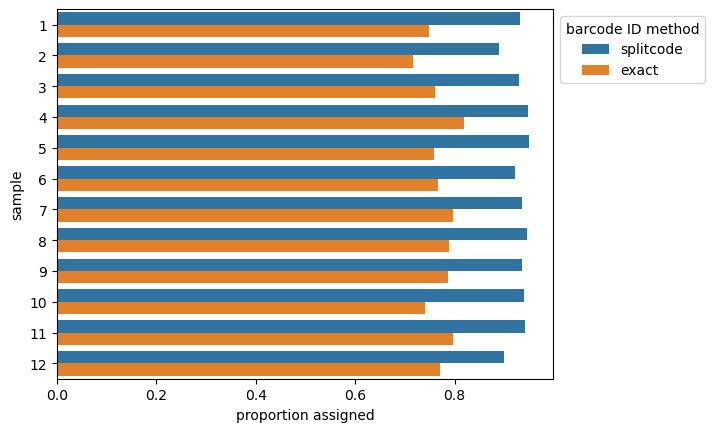

In [22]:
ax = sns.barplot(
    (
        df_data
        .drop_duplicates('sample')
        .assign(
            splitcode=df_data['n_assigned'] / df_data['n_reads'],
            exact=df_data['n_assigned_exact'] / df_data['n_reads'])
        .melt(
            id_vars='sample',
            value_vars=['splitcode', 'exact'],
            var_name='barcode ID method',
            value_name='proportion assigned'
        )
        .astype({'sample': 'category'})
    ),
    x='proportion assigned',
    y='sample',
    hue='barcode ID method',
)
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
ax.figure.show()

In [23]:
print('Barcode identification statistics:', end='\n\n')
pd.concat(
    (df_data.drop_duplicates('sample').pipe(lambda df: df['n_assigned'] / df['n_reads']).describe().rename('splitcode'),
     df_data.drop_duplicates('sample').pipe(lambda df: df['n_assigned_exact'] / df['n_reads']).describe().rename('exact')),
    axis=1
)

Barcode identification statistics:



splitcode      exact
count  12.000000  12.000000
mean    0.930515   0.770736
std     0.019058   0.028730
min     0.889357   0.715776
25%     0.927901   0.755916
50%     0.935842   0.768129
75%     0.942665   0.790510
max     0.950467   0.819296

In [24]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
n_total="$(unpigz -c "$DIR_PROC"/read_barcodes-*.txt.gz | wc -l)"
n_umis="$(
    unpigz -c "$DIR_PROC"/read_barcodes-*.txt.gz |
    grep -E -e 'RX:Z:[ATCGN-]*N' |
    wc -l
)"
echo "Number of UMIs by containing Ns: $n_umis out of $n_total total assigned reads"

Number of UMIs by containing Ns: 1365 out of 689604 total assigned reads


The rate of assignment (i.e., full barcode detection) here is significantly higher than in the previous sequencing run (20240620), perhaps reflecting the higher quality scores of this run.

## Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [barcode + UMI]
  - format: n/a
  - `id_vars`: `sample`, `R5`, `R5_2`, `R6`, `R6_2`, `R7`, `R7_2`, `R8`, `R8_2`, `umi`, `umi_2`
  - `value_vars`: `count`
- `df_barcode_counts`: counts per barcode
  - format: wide
  - `id_vars`: `sample`, `R5`, `R6`, `R7`, `R8`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: deduplicated counts per tag
  - format: long
  - `id_vars`: `sample`, `count_type`, `round`, `tag`
  - `value_vars`: `count`

In [25]:
path_umi_validation = os.path.join(DIR_RESULTS, 'umi_validation.csv')
path_tag_counts = os.path.join(DIR_RESULTS, 'tag_counts.csv')
path_barcode_counts = os.path.join(DIR_RESULTS, 'barcode_counts.csv')
path_umi_ecdf = os.path.join(DIR_RESULTS, 'umi_ecdf.csv')

In [26]:
reprocess = reprocess or not all(os.path.exists(path) for path in [path_umi_validation, path_tag_counts, path_barcode_counts, path_umi_ecdf])
print('reprocess:', reprocess)

reprocess: True


In [27]:
regex_barcode = re.compile((
    r'\[LigEven\]'
    r'\[OddTop_1\]'
    r'\[LigR4\]'
    r'\[R5Top_(?P<R5>\d+)\]'
    r'\[LigR5\]'
    r'\[R6Top_(?P<R6>\d+)\]'
    r'\[R8StgBot_(?P<R8>\d+)\]'
    r'\[R7\]'
    r'\[R7Bot_(?P<R7>\d+)\]'
    r'\[R6\]'
    r'\[R6Bot_(?P<R6_2>\d+)\]'
    r'\[R5\]'
    r'\[R5Bot_(?P<R5_2>\d+)\]'
    r'\[R4\]'
    r'\[OddBot_1\]'
    r'\[Even\]'
    r'\[2Puni\]'
    r'\[2Puni_2\]'
    r'\s+'
    r'RX:Z:(?P<umi>[ACGNT]*)-(?P<umi_2>[ACGNT]*)'
))

DTYPE_SAMPLE = pd.api.types.CategoricalDtype(categories=list(df_data['sample'].unique()))
DTYPE_COUNT_TYPE = pd.api.types.CategoricalDtype(categories=['raw', 'dedup'])
DTYPE_ROUNDS = pd.api.types.CategoricalDtype(categories=ROUNDS)

def count_barcodes(sample, regex, path_barcodes=None):
    '''
    From the read_barcodes file generated from a given sample and splitcode config,
    count the barcodes and UMIs, and tabulate in pandas DataFrames.

    Args
    - sample: str
        Sample name
    - regex: re.Pattern
        Regular expression pattern for barcode. Should contain named capture groups.
    
    Returns
    - df_barcode_counts: pandas.DataFrame
      - Only includes reads associated with 12 bp UMIs containing no Ns,
        and where the barcode identified from the forward and reverse reads match
      - Columns
        - R1, R2, R3, R4: np.uint8
        - count: np.int64
        - count_dedup: np.int64
        - sample: DTYPE_SAMPLE
    - df_umi_counts: pandas.DataFrame
      - R1, R2, R3, R4, R1_2, R2_2, R3_2, R4_2: np.uint8
      - umi, umi_2: str
      - count: np.int64
      - sample: DTYPE_SAMPLE
    - n_unmatched: int
        Number of reads whose barcodes did not match the provided regex.
    '''
    if path_barcodes is None:
        path_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    with gzip.open(path_barcodes, 'rt') as f:
        df_umi_counts, n_unmatched, unmatched = parse_barcodes.barcodes_to_df(f, regex)
    if len(df_umi_counts) > 0:
        df_umi_counts = (
            df_umi_counts
            .fillna(0)
            .astype({k: np.uint8 for k in ROUNDS + ['R5_2', 'R6_2']})
            .groupby(list(df_umi_counts.columns), observed=True).size()
            .reset_index().rename(columns={0: 'count'})
        )
    else:
        df_umi_counts = pd.DataFrame([], columns=ROUNDS + ['R5_2', 'R6_2', 'umi', 'umi_2', 'count'])
    df_barcode_counts = (
        df_umi_counts
        .loc[
            (~df_umi_counts['umi'].str.contains('N')) & \
            (df_umi_counts['umi'].map(len) == 12) & \
            (df_umi_counts['umi'] == df_umi_counts['umi_2']) & \
            (df_umi_counts['R5'] == df_umi_counts['R5_2']) & \
            (df_umi_counts['R6'] == df_umi_counts['R6_2'])
        ]
        .drop(columns=['R5_2', 'R6_2', 'umi_2'])
        .groupby(ROUNDS, observed=True)["count"]
        .agg(["count", "sum"])
        .reset_index()
        .rename(columns={"count": "count_dedup", "sum": "count"})
    )
    df_barcode_counts['sample'] = pd.Series([sample] * len(df_barcode_counts), dtype=DTYPE_SAMPLE)
    df_umi_counts['sample'] = pd.Series([sample] * len(df_umi_counts), dtype=DTYPE_SAMPLE)
    return df_barcode_counts, df_umi_counts, n_unmatched, unmatched

In [28]:
def umi_df_to_validation(df, n_unmatched=None):
    '''
    Compute summary validation metrics from a UMI counts table (e.g., df_umi_counts).

    Args
    - df: pandas.DataFrame
        Columns must include 'umi' and 'count'. In this notebook, usually df_umi_counts.
    - n_unmatched: int or None
        Number of unmatched reads

    Returns: pandas.DataFrame
    - metric: str
        'RX mismatch', 'N in UMI', or 'n_unmatched'
    - count_type: str
        'raw' or 'dedup'
    - count: int or None
    '''
    entries = []

    # reads with different RX tag identified in read 1 versus read 2
    for r in ['R5', 'R6', 'umi']:
        mask_mismatch = df[r] != df[r + '_2']
        entries.append(dict(metric=f'{r} mismatch', count_type='raw', count=df.loc[mask_mismatch, 'count'].sum()))
        entries.append(dict(metric=f'{r} mismatch', count_type='dedup', count=mask_mismatch.sum()))

    # reads with UMIs containing Ns
    mask_ns = df['umi'].str.contains('N') | df['umi_2'].str.contains('N')
    entries.append(dict(metric='N in UMI', count_type='raw', count=df.loc[mask_ns, 'count'].sum()))
    entries.append(dict(metric='N in UMI', count_type='dedup', count=mask_ns.sum()))

    # reads unmatched
    entries.append(dict(metric='n_unmatched', count_type='raw', count=n_unmatched))
    return pd.DataFrame(entries)

In [29]:
if reprocess:
    df_umi_val_all = {}
    df_umi_ecdf = {}
    df_barcode_counts_all = {}

In [30]:
if reprocess:
    for sample in df_data['sample'].unique():
        df_barcode_counts, df_umi_counts, n_unmatched, unmatched = count_barcodes(sample, regex_barcode)
        if n_unmatched > 0:
            print((
                f'Sample {sample}: {n_unmatched} reads had barcodes [+ UMIs] that did not match '
                f'the regex. {min(3, n_unmatched)} / {n_unmatched} unmatched barcode-appended '
                'read names are printed below:'))
            for i in range(min(3, n_unmatched)):
                print('-', unmatched[i])
        df_umi_val_all[sample] = (
            umi_df_to_validation(df_umi_counts, n_unmatched)
            .assign(sample=sample)
            .astype(dict(sample=DTYPE_SAMPLE))
        )
        df_umi_ecdf[sample] = df_umi_counts['count'].value_counts()
        df_barcode_counts_all[sample] = df_barcode_counts.assign(sample=sample).astype(dict(sample=DTYPE_SAMPLE))

### Save / Load Processed Data

In [31]:
if reprocess:
    df_umi_val_all = pd.concat(df_umi_val_all.values(), axis=0, ignore_index=True)
    df_umi_val_all.to_csv(path_umi_validation, index=False)
else:
    df_umi_val_all = pd.read_csv(
        path_umi_validation,
        index_col=False,
        dtype=dict(sample=DTYPE_SAMPLE, count_type=DTYPE_COUNT_TYPE))

In [32]:
if reprocess:
    df_barcode_counts_all = pd.concat(df_barcode_counts_all.values(), axis=0, ignore_index=True)
    df_barcode_counts_all.to_csv(path_barcode_counts, index=False)
else:
    df_barcode_counts_all = pd.read_csv(
        path_barcode_counts,
        dtype={
            'R5': np.uint8,
            'R6': np.uint8,
            'R7': np.uint8,
            'R8': np.uint8,
            'count': np.int64,
            'count_dedup': np.int64,
            'sample': DTYPE_SAMPLE
        },
        index_col=False
    )

In [33]:
if reprocess:
    df_umi_ecdf_long = (
        pd.concat((pd.concat((pd.Series(0), s)) for s in df_umi_ecdf.values()), axis=1)
        .fillna(0)
        .astype(int)
        .sort_index()
        .reset_index(names='count')
        .melt(id_vars='count', var_name='sample', value_name='frequency')
        .groupby('sample', group_keys=False)
        .apply(lambda g: (
            g.sort_values('count')
            .pipe(lambda g2: g.assign(cumulative_prop=g['frequency'].cumsum() / g['frequency'].sum()))
        ))
        .pipe(lambda df: df.assign(sample=df['sample'].map(lambda i: list(df_umi_ecdf.keys())[i])))
    )
    df_umi_ecdf_long.to_csv(path_umi_ecdf, index=False)
else:
    df_umi_ecdf_long = pd.read_csv(path_umi_ecdf, index_col=False, dtype={'sample': DTYPE_SAMPLE})

/tmp/ipykernel_176379/822442639.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (


In [34]:
if reprocess:
    df_tag_counts = (
        df_barcode_counts_all
        .rename(columns=dict(count='raw', count_dedup='dedup'))
        .melt(
            id_vars=ROUNDS + ['sample'],
            var_name='count_type',
            value_name='count'
        )
        .melt(
            id_vars=['sample', 'count_type', 'count'],
            value_vars=ROUNDS,
            var_name='round',
            value_name='tag'
        )
        .groupby(['sample', 'count_type', 'round', 'tag'], observed=True)
        ['count'].sum()
        .reset_index()
        .astype(dict(round=DTYPE_ROUNDS, count_type=DTYPE_COUNT_TYPE))
    )
    df_tag_counts.to_csv(path_tag_counts, index=False)
else:
    df_tag_counts = pd.read_csv(
        path_tag_counts,
        index_col=False,
        dtype=dict(
            sample=DTYPE_SAMPLE,
            count_type=DTYPE_COUNT_TYPE,
            round=DTYPE_ROUNDS,
            tag=np.uint8
        )
    )

# Validation

All assigned reads had read structures and UMIs matching expected regex.

In [35]:
df_umi_val_all.loc[df_umi_val_all['metric'] == 'n_unmatched', 'count'].unique()

array([0])

A negligible proportion of reads have different tags identified in read 1 vs. read 2, but there was a more sizeable proportion (up to ~5%) of reads with different UMIs identified in read 1 vs. read 2.

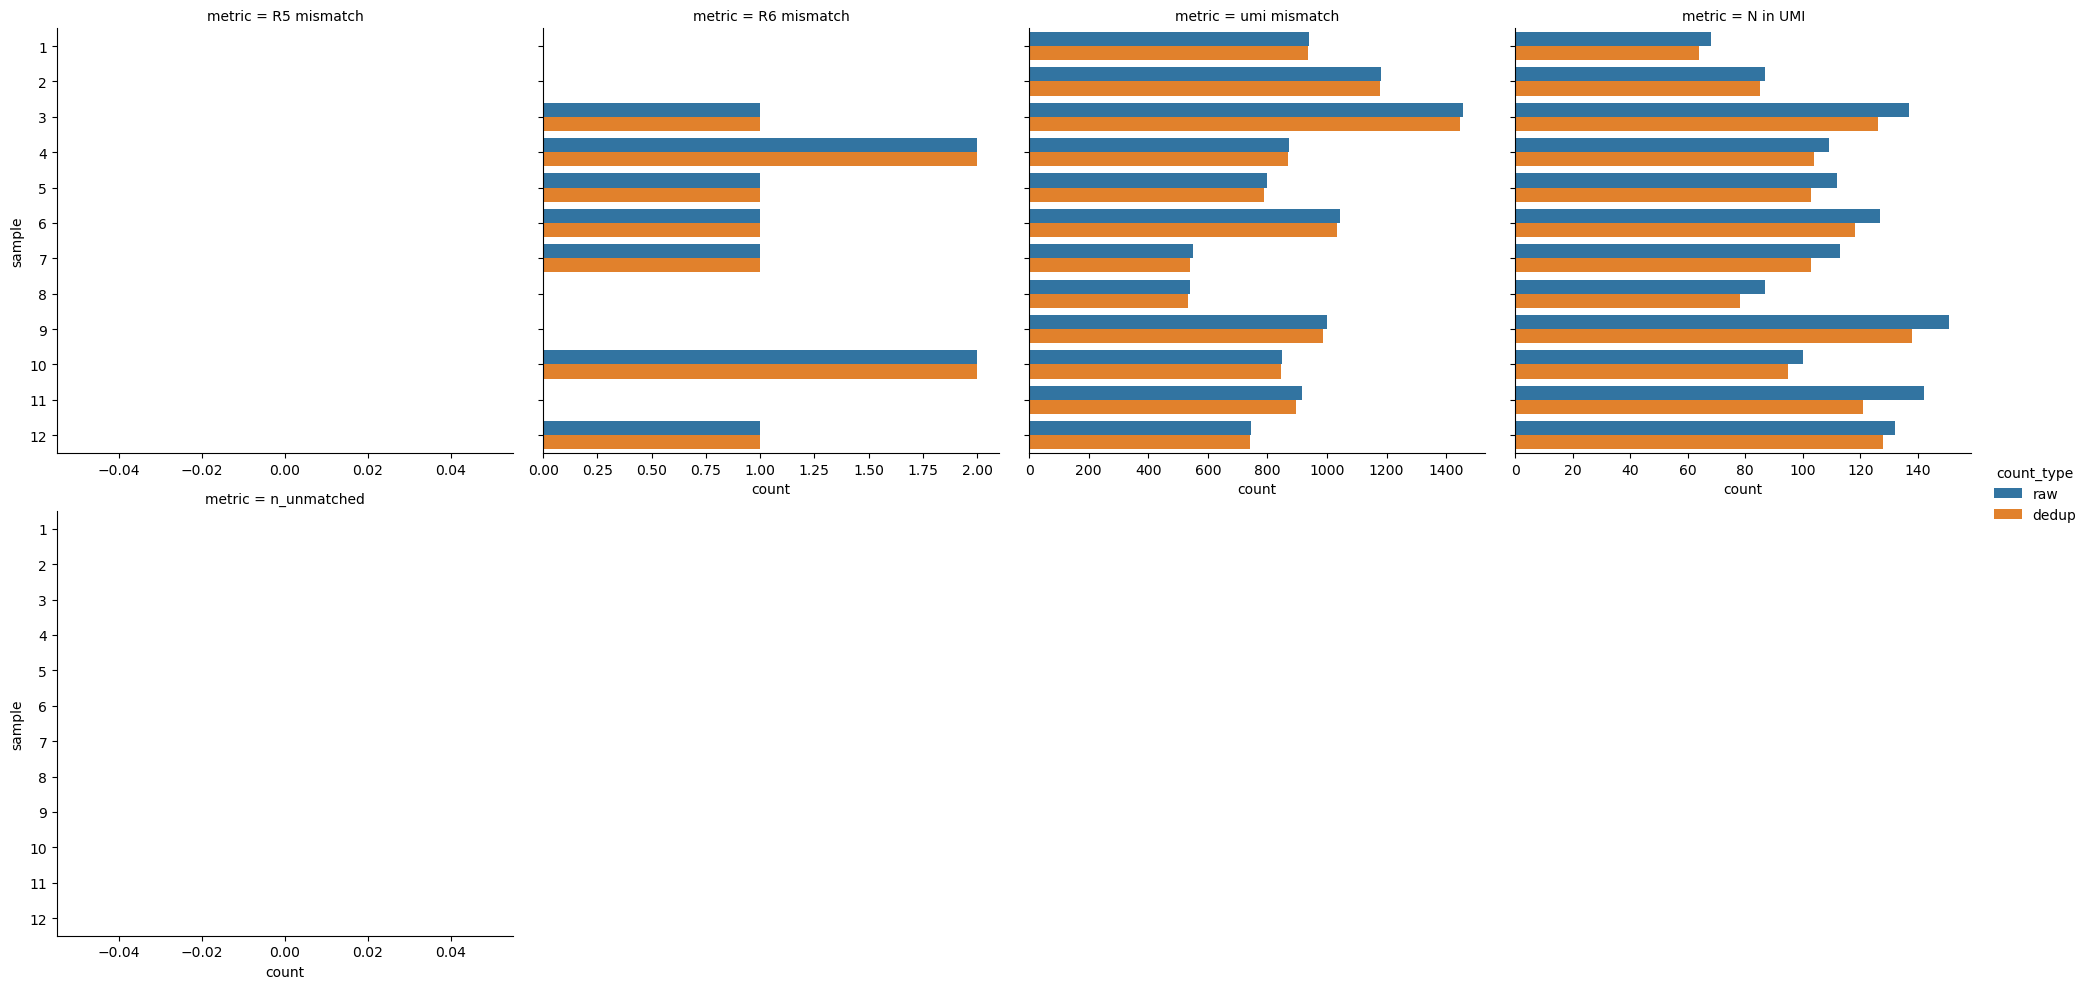

In [36]:
g = sns.catplot(
    kind='bar',
    data=df_umi_val_all,
    x='count',
    y='sample',
    hue='count_type',
    col='metric',
    col_wrap=4,
    sharex=False
)

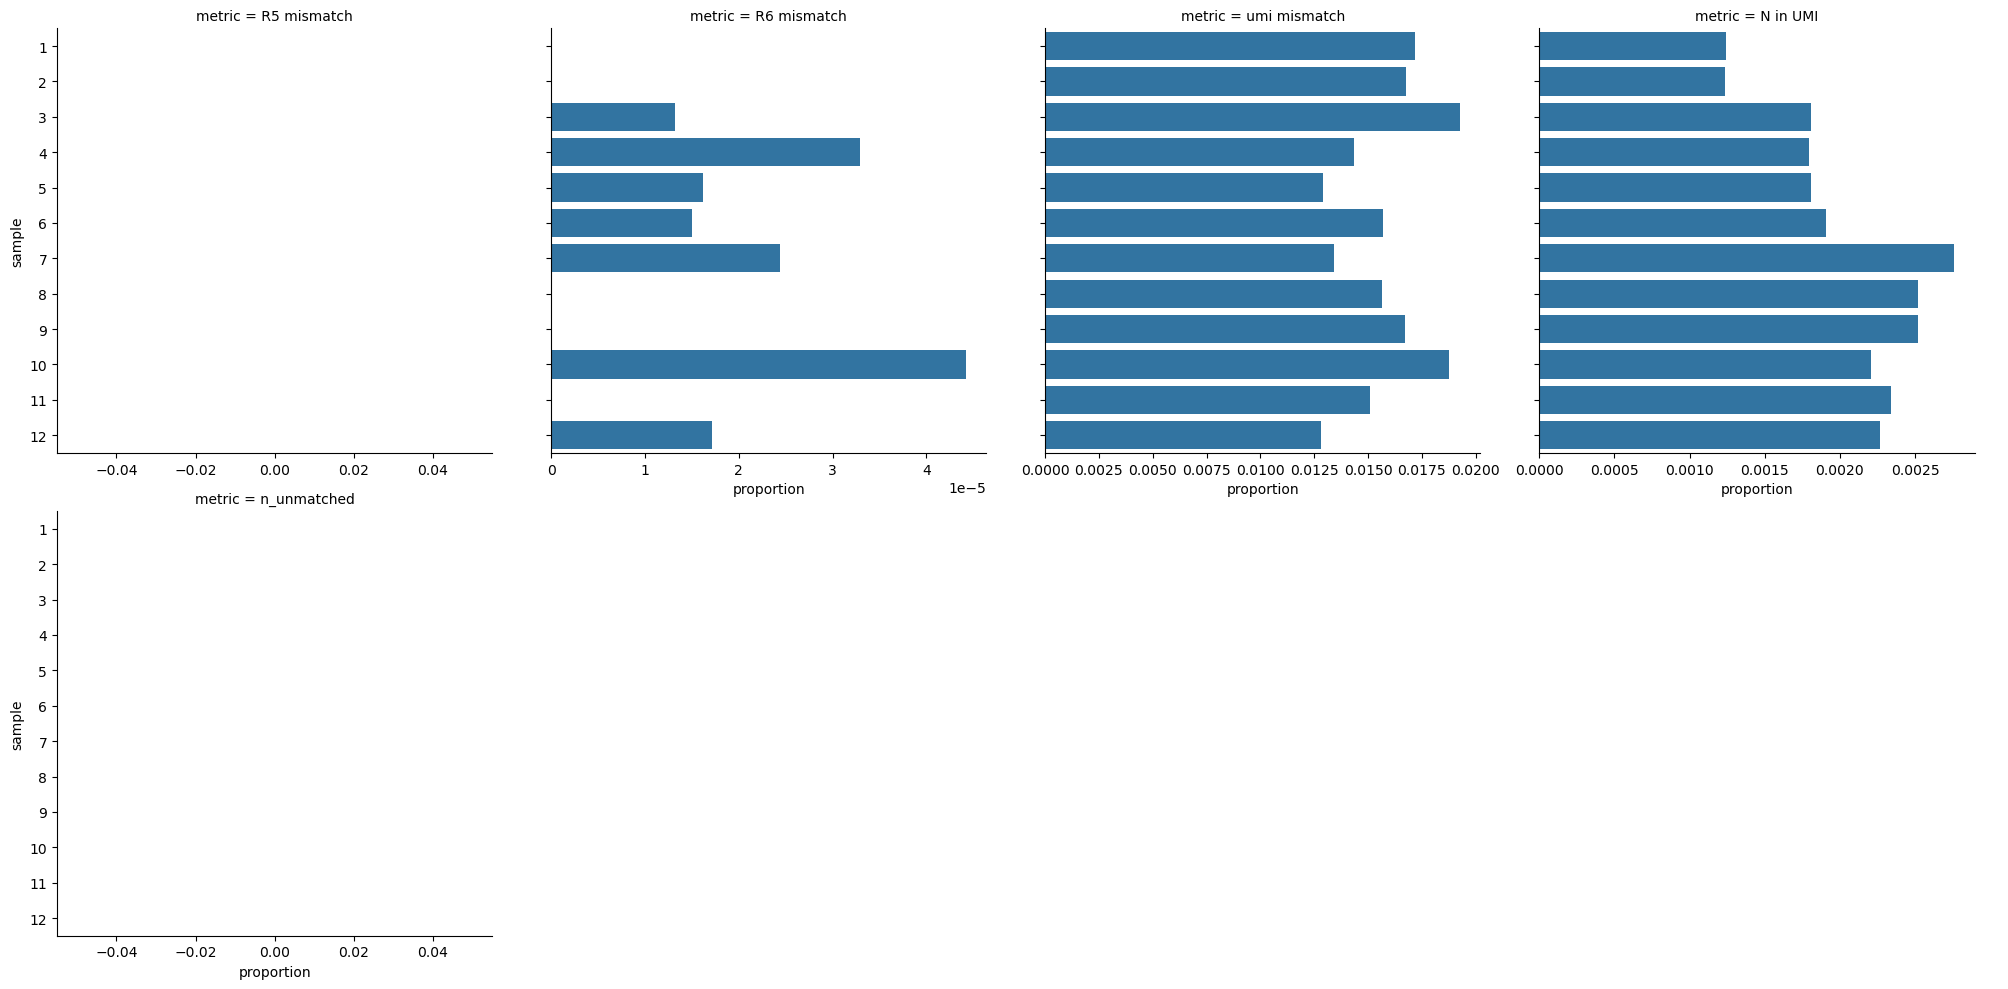

In [37]:
g = sns.catplot(
    kind='bar',
    data=(
        df_umi_val_all
        .loc[df_umi_val_all['count_type'] == 'raw']
        .drop(columns='count_type')
        .merge(df_data[['sample', 'n_assigned']].drop_duplicates('sample'))
        .pipe(lambda df: df.assign(proportion=df['count'] / df['n_assigned']))
        [['metric', 'sample', 'proportion']]
        .astype({'sample': 'category'})
    ),
    x='proportion',
    y='sample',
    col='metric',
    col_wrap=4,
    color='C0',
    sharex=False
)

# Ligation QC

Tag counts faceted by sample and round, grouped (colored) by count type (raw or deduplicated)

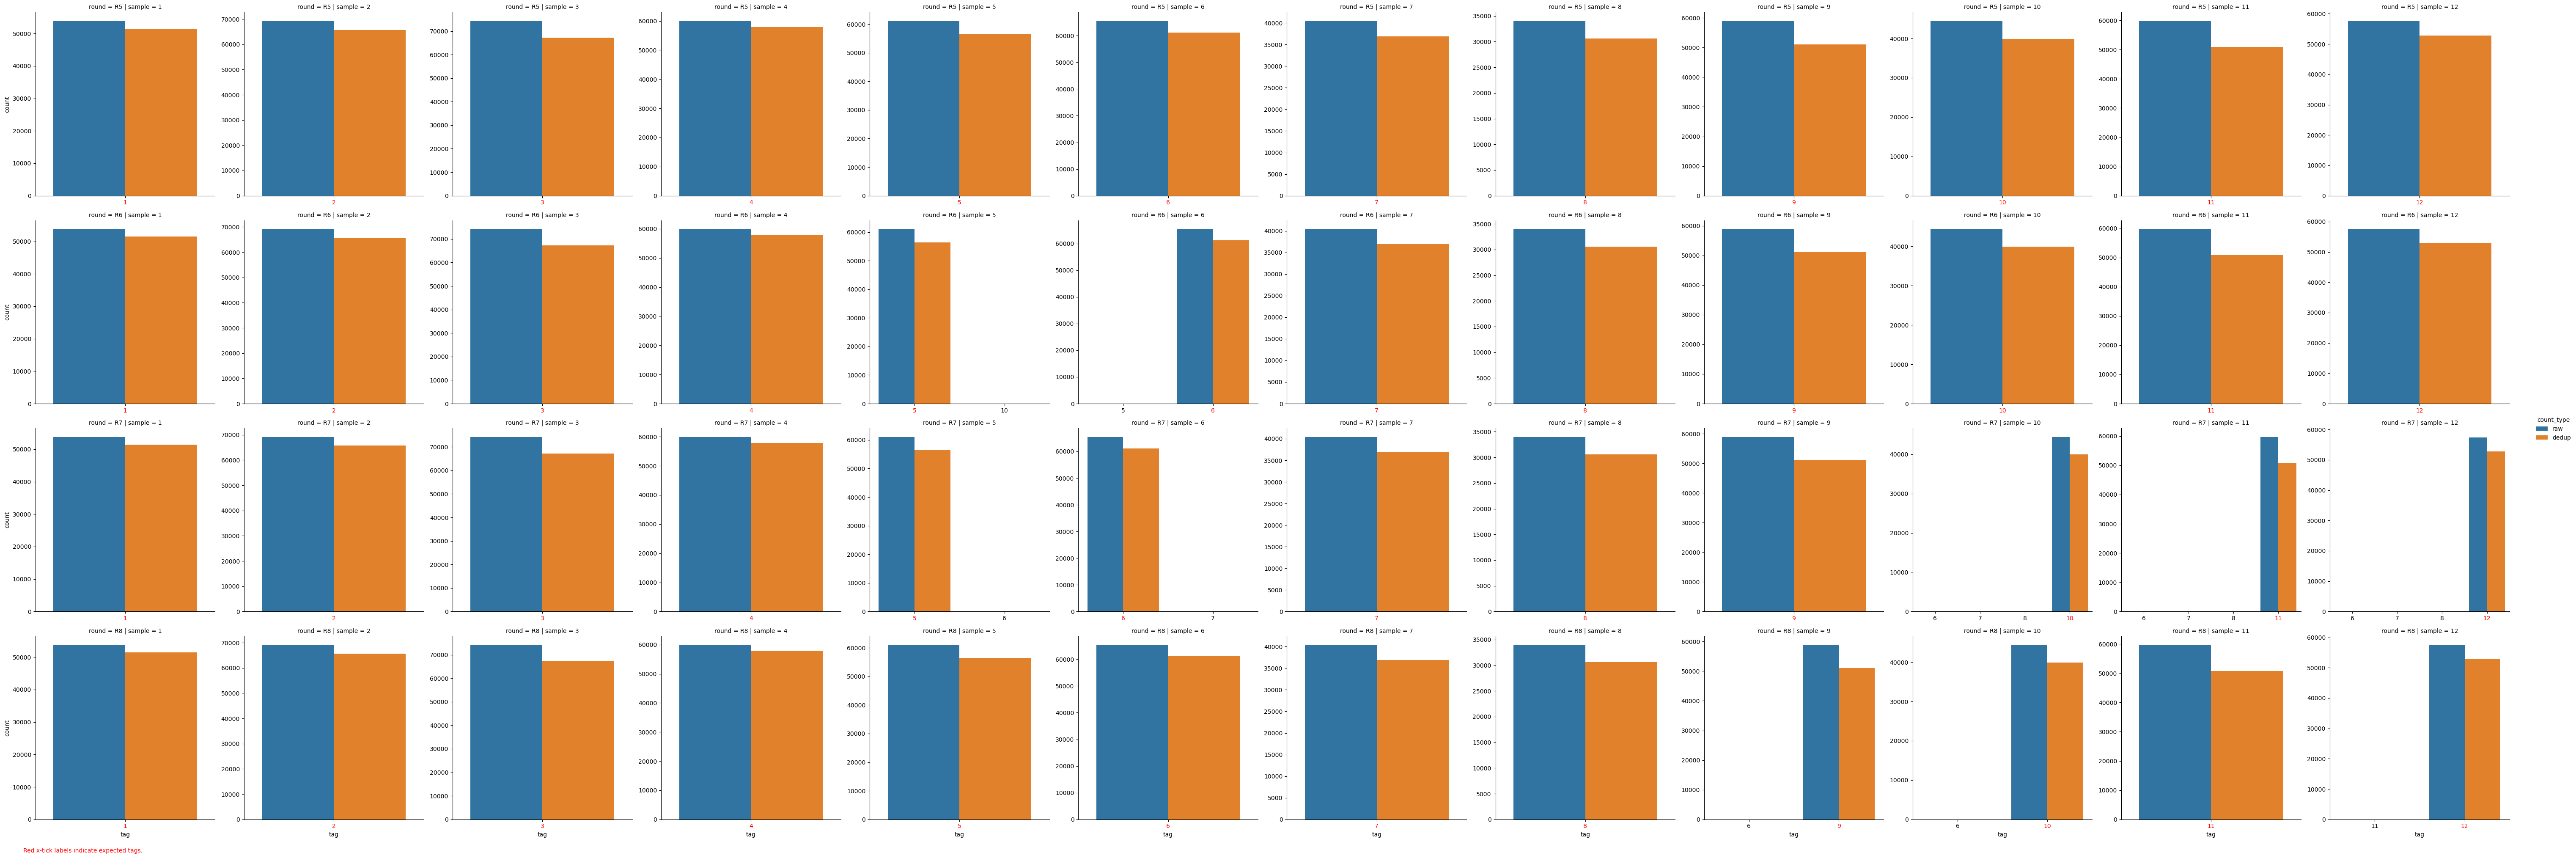

In [38]:
g = sns.catplot(
    df_tag_counts,
    kind='bar',
    x='tag',
    y='count',
    row='round',
    row_order=ROUNDS,
    hue='count_type',
    col='sample',
    sharex=False,
    sharey='col'
)

# red color for xticklabels corresponding to expected tag
for (r, sample), ax in g.axes_dict.items():
    for text in ax.get_xticklabels():
        if int(text.get_text()) == sample:
            text.set_color('red')
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

g.figure.text(
    0.01,
    -0.01,
    'Red x-tick labels indicate expected tags.',
    color='red',
    ha='left'
)

g.figure.savefig(
    os.path.join(DIR_RESULTS, 'tag_counts_by_sample.pdf'),
    bbox_inches='tight',
    dpi=300
)

Flow diagram (Sankey / parallel categories plot)

In [39]:
for sample in df_barcode_counts_all['sample'].unique():
    path_parcats = os.path.join(DIR_RESULTS, f'parcats_{sample}.pdf')
    if not os.path.exists(path_parcats) or reprocess:
        mask_sample = (df_barcode_counts_all['sample'] == sample)
        fig = go.Figure(go.Parcats(
            dimensions=[
                {
                    'label': r,
                    'values': df_barcode_counts_all.loc[mask_sample, r],
                    'categoryorder': 'category ascending'
                } for r in ROUNDS
            ],
            counts=df_barcode_counts_all.loc[mask_sample, 'count_dedup']))
        fig.update_layout(
            title_text=f'Sample: {sample}',
            width=600,
            height=600,
            margin=dict(l=10, b=10, t=50, r=10)
        )
        # fig.show()
        fig.write_image(path_parcats)

Count (or proportion of total count) per barcode (akin to scSPRITE Figure 1C)

In [40]:
fig = px.line(
    (
        df_barcode_counts_all
        .groupby('sample', group_keys=False)
        .apply(lambda g:
           g.assign(
               rank=np.argsort(np.argsort(-g['count_dedup'])),
               proportion=g['count_dedup'] / g['count_dedup'].sum()
           ).pipe(lambda g2: g2.loc[g2['rank'] < 6]))
        .reset_index()
        .melt(id_vars=['sample', 'rank'], value_vars=['count', 'proportion'], var_name='metric')
        .sort_values(['sample', 'rank'])
    ),
    x='rank',
    y='value',
    color='sample',
    facet_row='metric',
    markers=True,
    category_orders=dict(sample=sorted(df_data['sample'].unique())),
    color_discrete_sequence=sns.color_palette('cividis', n_colors=len(df_data['sample'].unique())).as_hex(),
    labels={'rank': 'barcode rank'}
)
fig.update_yaxes(
    matches=None,
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_xaxes(
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_layout(
    margin=dict(l=0, b=10, t=50, r=10),
    height=600,
    width=800,
    plot_bgcolor='#fff'
)
fig.write_image(os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank.png'), scale=2)
fig.show()

/tmp/ipykernel_176379/1000479752.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_176379/1000479752.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/home/btyeh/miniconda3/envs/py3/lib/python3.11/site-packages/plotly/express/_core.py:1971: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Proportion of barcodes from each sample that are correct.

In [41]:
mask_expected_barcodes = functools.reduce(lambda x, y: x & y, (df_barcode_counts_all[r] == df_barcode_counts_all['sample'] for r in ROUNDS))
total_barcode_counts = df_barcode_counts_all.groupby('sample')['count_dedup'].sum()
df_barcode_proportion_correct = (
    df_barcode_counts_all
    .loc[mask_expected_barcodes]
    .set_index('sample')
    .drop(columns='count')
    .pipe(lambda df: df.assign(proportion=df['count_dedup'] / total_barcode_counts))
)
display(df_barcode_proportion_correct)
df_barcode_proportion_correct['proportion'].describe()

/tmp/ipykernel_176379/1362517243.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



R5  R6  R7  R8  count_dedup  proportion
sample                                         
1        1   1   1   1        51451    1.000000
2        2   2   2   2        65691    1.000000
3        3   3   3   3        67211    1.000000
4        4   4   4   4        57848    1.000000
5        5   5   5   5        56420    0.999947
6        6   6   6   6        61155    0.999967
7        7   7   7   7        36912    1.000000
8        8   8   8   8        30587    1.000000
9        9   9   9   9        51117    0.999980
10      10  10  10  10        39918    0.999674
11      11  11  11  11        50811    0.999587
12      12  12  12  12        52712    0.998031

count    12.000000
mean      0.999766
std       0.000564
min       0.998031
25%       0.999879
50%       0.999990
75%       1.000000
max       1.000000
Name: proportion, dtype: float64

## Direct calculation of contamination

### Contamination by well

Barcodes are so clean that at least 3 of the 4 rounds of barcodes are "correct" for each barcode.

In [42]:
for _, row in df_barcode_counts_all.iterrows():
    well, count = collections.Counter(row[ROUNDS]).most_common(1)[0]
    if count <= 2:
        display(row)

Consequently, we can use the metric that 3 out of 4 rounds come from the same well as the "ground truth."

In [43]:
contamination = dict()
sensitivity = dict()
for well in range(1, 13):
    for r in ROUNDS:
        # number of oligos in the well: where other 3 rounds have tags matching the well
        mask = pd.Series([True] * len(df_barcode_counts_all))
        for r2 in ROUNDS:
            if r2 != r:
                mask &= df_barcode_counts_all[r2] == well
        total = df_barcode_counts_all.loc[mask, 'count_dedup'].sum()
        contaminated = df_barcode_counts_all.loc[mask & (df_barcode_counts_all[r] != well), 'count_dedup'].sum()
        contamination[(r, well)] = contaminated / total
        sensitivity[(r, well)] = 1 / total

In [44]:
df_contaminated = (
    pd.Series(contamination).reset_index()
    .rename(columns={'level_0': 'round', 'level_1': 'well', 0: 'proportion_contaminated'})
)
df_contaminated['col'] = (df_contaminated['well'] - 1) % 12 + 1
df_contaminated['row'] = (
    (df_contaminated['round'].str.extract('(\d)', expand=False).astype(int) - 5) * 2 + 
    (df_contaminated['well'] - 1) // 12
).map(lambda x: chr(ord('A') + x))
df_contaminated['round-row'] = df_contaminated['round'] + '-' + df_contaminated['row']

In [45]:
df_contaminated_wide = df_contaminated.pivot(index='round', columns='well', values='proportion_contaminated')
df_contaminated_wide_plate = df_contaminated.pivot(index='round-row', columns='col', values='proportion_contaminated')

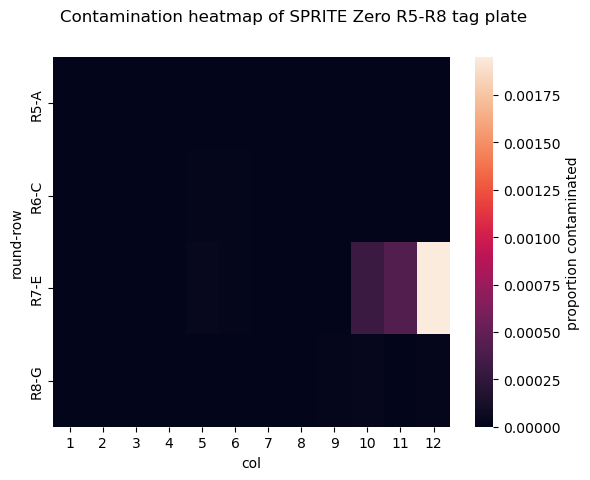

In [46]:
ax = sns.heatmap(df_contaminated_wide_plate, cbar_kws={'label': 'proportion contaminated'})
ax.figure.suptitle('Contamination heatmap of SPRITE Zero R5-R8 tag plate')
ax.figure.savefig(
    os.path.join(DIR_RESULTS, 'contamination_heatmap_of_tag_plate.png'),
    bbox_inches='tight',
    dpi=300
)

In [47]:
print('Maximum tag well contamination proportion:', df_contaminated['proportion_contaminated'].max())

Maximum tag well contamination proportion: 0.0019502035406607971


In [48]:
print('Minimum sensitivity of assay:', '{:f}'.format(max(sensitivity.values())))

Minimum sensitivity of assay: 0.000033


#### Bayesian modeling of contamination proportion

We can model the proportion contamination using a Bayesian model:
- Let $X$ be the observed count of contaminated tags. Let $n$ be the number of total observed tags, and $p$ be the true proportion of contaminated tags.
- Binomial likelihood: $X \mid n, p \sim \mathrm{Binom}(n, p)$
  - We model $n$ (the number of assigned, deduplicated reads) as a known, fixed number.
- Prior (we choose a conjugate prior for convenience): $p \sim \mathrm{Beta}(\alpha = 0.4998, \beta = 49.21)$
  - Corresponds to placing 95% density between 0.00001 and 0.05 - see [Justin Bois's Distribution Explorer](https://distribution-explorer.github.io/continuous/beta.html).

By conjugacy, the posterior distribution is
$p \sim \mathrm{Beta}(\alpha + x, \beta + n - x)$

We compute the median and 2.5th to 97.5th percentiles of the posterior distribution of proportion contamination for each well.

In [49]:
alpha = 0.4998
beta = 49.21
prop_contamination_range = dict()
for well in range(1, 13):
    for r in ROUNDS:
        n = round(1 / sensitivity[(r, well)])
        x = round(contamination[(r, well)] * n)
        alpha_post = alpha + x
        beta_post = beta + n - x
        lb = scipy.stats.beta.ppf(0.025, alpha_post, beta_post)
        med = scipy.stats.beta.ppf(0.5, alpha_post, beta_post)
        assert np.isclose(med, scipy.stats.beta.median(alpha_post, beta_post), atol=1e-10)
        ub = scipy.stats.beta.ppf(0.975, alpha_post, beta_post)
        prop_contamination_range[(r, well)] = (lb, med, ub)

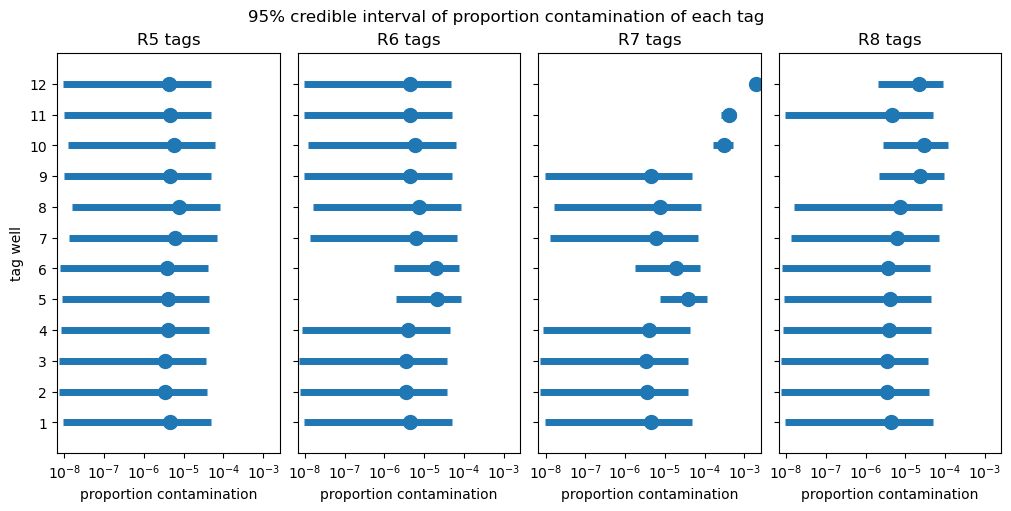

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(10, 5), constrained_layout=True)
for i, r in enumerate(ROUNDS):
    axs[i].set_title(f'{r} tags')
    segs = []
    for well in range(1, 13):
        # line = (x0, y0), (x1, y1)
        lb, med, ub = prop_contamination_range[(r, well)]
        line = [(lb, well), (ub, well)]
        segs.append(line)
        axs[i].scatter(med, well, s=100, c='C0')
    line_segments = matplotlib.collections.LineCollection(segs, linewidths=5, linestyle='solid')
    axs[i].add_collection(line_segments)
    axs[i].set_xlabel('proportion contamination')
axs[0].set(
    xlim=(min(lb for lb, _, _ in prop_contamination_range.values()) * 0.9,
          max(ub for _, _, ub in prop_contamination_range.values()) * 1.1),
    ylim=(0, 13),
    xscale='log',
    ylabel='tag well'
)
axs[0].set_yticks(range(1, 13))
axs[0].set_xticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3])
fig.suptitle('95% credible interval of proportion contamination of each tag')
fig.savefig(os.path.join(DIR_RESULTS, 'contamination_credible_intervals.pdf'), bbox_inches='tight')

In [51]:
print('Maximum of 97.5% percentile of proportion contamination across all tags:',
      max(ub for _, _, ub in prop_contamination_range.values()))

Maximum of 97.5% percentile of proportion contamination across all tags: 0.002352149589108479


### Contamination by sample

Contamination is identical whether computed by well or by i5/i7 multiplexing sequencing index. Looking at the parallel coordinate plots, it seems like the multiplexing sequencing indices are exceptionally clean, and any contamination observed is from the tags.

In [52]:
purity_per_sample = df_barcode_counts_all.groupby('sample').apply(lambda g: g['count_dedup'].max() / g['count_dedup'].sum())

/tmp/ipykernel_176379/3463084045.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_176379/3463084045.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [53]:
purity_per_well = dict()
for well in range(1, 13):
    # mask to specify any row (i.e., sample-barcode combination) in df_barcode_counts_all
    # that has 3+ rounds matching the target well
    mask_all = pd.Series([False] * len(df_barcode_counts_all))

    # mask to specify rows where all 4 rounds match the target well
    mask_pure = pd.Series([True] * len(df_barcode_counts_all))
    for r in ROUNDS:
        # number of oligos in the well: where other 3 rounds have tags matching the well
        mask = pd.Series([True] * len(df_barcode_counts_all))
        for r2 in ROUNDS:
            if r2 != r:
                mask &= df_barcode_counts_all[r2] == well
        mask_all |= mask
        mask_pure &= df_barcode_counts_all[r] == well
    total = df_barcode_counts_all.loc[mask_all, 'count_dedup'].sum()
    pure = df_barcode_counts_all.loc[mask_pure, 'count_dedup'].sum()
    purity_per_well[well] = pure / total
purity_per_well = pd.Series(purity_per_well)

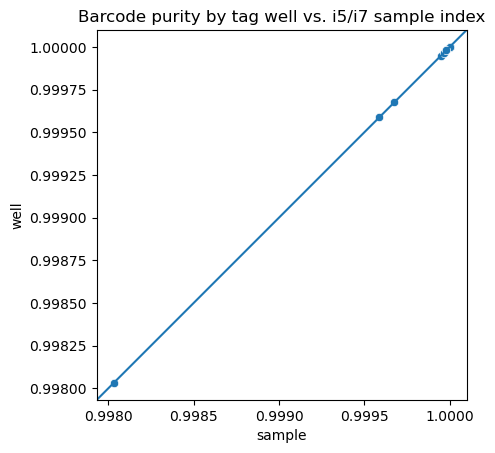

In [54]:
df_purity = pd.concat((purity_per_sample, purity_per_well), axis=1).rename(columns={0: 'sample', 1: 'well'})
ax = sns.scatterplot(df_purity, x='sample', y='well')
ax.axline((1, 1), slope=1)
ax.set_aspect('equal')
ax.set_title('Barcode purity by tag well vs. i5/i7 sample index')
ax.set(ylim=ax.get_xlim())
ax.figure.savefig(os.path.join(DIR_RESULTS, 'tag-purity_vs_i5-i7-sample-index-purity.pdf'), bbox_inches='tight')

# Sequencing Depth and Duplicates

## UMI distribution

In [55]:
umi_distribution = (
    df_umi_ecdf_long.groupby('count')['frequency'].sum()
    .pipe(lambda s: s/s.sum()).rename('proportion')
)
display(umi_distribution)
print('mean UMI count: {:.3f}'.format((np.array(umi_distribution.index) * umi_distribution).sum()))

count
0    0.000000
1    0.913740
2    0.082793
3    0.003390
4    0.000071
5    0.000006
Name: proportion, dtype: float64

mean UMI count: 1.090


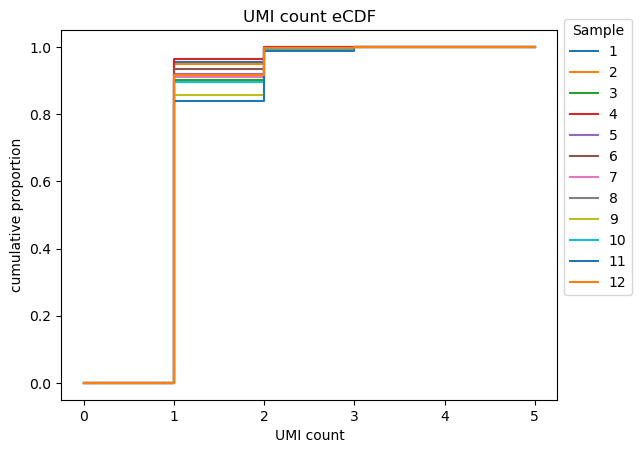

In [56]:
fig, ax = plt.subplots()
for sample in sorted(df_umi_ecdf_long['sample'].unique()):
    mask = (df_umi_ecdf_long['sample'] == sample)
    ax.step(
        df_umi_ecdf_long.loc[mask, 'count'],
        df_umi_ecdf_long.loc[mask, 'cumulative_prop'],
        where='post',
        label=sample
    )
ax.legend(title='Sample', loc='upper left', bbox_to_anchor=(1, 1.05))
ax.set(xlabel='UMI count', ylabel='cumulative proportion', title='UMI count eCDF', xticks=range(df_umi_ecdf_long['count'].max() + 1))
fig.show()

## Estimate library complexity

In [57]:
umi_complexity = 4**12
print('Maximum UMI complexity:', umi_complexity)

Maximum UMI complexity: 16777216


Estimate the complexity of all barcodes in each sample.

In [58]:
complexity_umi_all = df_barcode_counts_all.groupby('sample')[['count', 'count_dedup']].sum().apply(
    lambda s: estimate_library_complexity(s['count'], s['count_dedup']),
    axis=1)

/tmp/ipykernel_176379/3129981588.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [59]:
assert df_umi_ecdf_long.loc[df_umi_ecdf_long['count'] == 0, 'frequency'].sum() == 0
complexity_umi_all2 = (
    df_umi_ecdf_long
    .assign(total_count=df_umi_ecdf_long['frequency'] * df_umi_ecdf_long['count'])
    .groupby('sample')
    .apply(lambda g: estimate_library_complexity2(g['total_count'].sum(), g['total_count'].sum() / g['frequency'].sum()))
)

/tmp/ipykernel_176379/3876851406.py:6: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



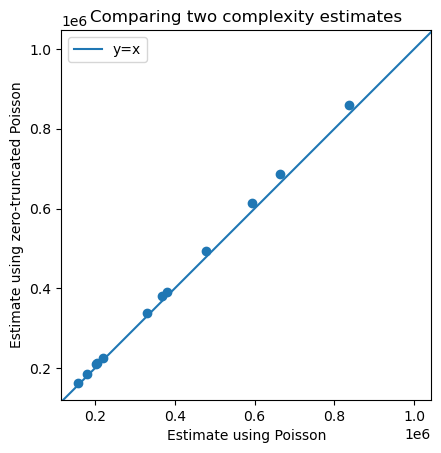

In [60]:
fig, ax = plt.subplots()
ax.scatter(complexity_umi_all, complexity_umi_all2)
ax.axline((1e6, 1e6), slope=1, label='y=x')
ax.set(
    xlabel='Estimate using Poisson',
    ylabel='Estimate using zero-truncated Poisson',
    title='Comparing two complexity estimates'
)
ax.axis('square')
ax.legend()
fig.show()

Estimate the complexity of the predominant barcode in each sample.

In [61]:
complexity_umi_top = (
    df_barcode_counts_all
    .groupby("sample", group_keys=True)
    .apply(lambda group: group.iloc[group["count"].argmax()][["count", "count_dedup"]])
    .apply(lambda s: estimate_library_complexity(s['count'], s['count_dedup']), axis=1)
)

/tmp/ipykernel_176379/4262779129.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_176379/4262779129.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



#### Using preseq

In [62]:
for sample, hist in df_umi_ecdf.items():
    hist.to_csv(os.path.join(DIR_PROC, f'umi_hist_{sample}.tsv'), sep='\t', index=True, header=False)

In [63]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

source ~/.bashrc
conda activate genomics

for ((sample=1; sample<=12; sample++)); do
    echo "Sample $sample"
    path_hist="${DIR_PROC}/umi_hist_${sample}.tsv"
    path_bound_pop="${DIR_PROC}/preseq-bound_pop-${sample}.tsv"
    preseq bound_pop -hist "$path_hist" > "$path_bound_pop"

    # Using lc_extrap or pop_size on any sample in this dataset throws an error
    # "ERROR:	too many defects in the approximation, consider running in defect mode"
    # while disabling error checking via the -D flag results in some uninterpretable negative estimates.
    # This is probably due to histograms with too few counts above 1.
    #
    # path_lc_extrap="${DIR_PROC}/preseq-lc_extrap-${sample}.tsv"
    # path_pop_size="${DIR_PROC}/preseq-pop_size-${sample}.tsv"
    # preseq lc_extrap -hist "$path_hist" > "$path_lc_extrap"
    # preseq pop_size -hist "$path_hist" > "$path_pop_size"
done

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Sample 6
Sample 7
Sample 8
Sample 9
Sample 10
Sample 11
Sample 12


In [64]:
df_preseq_estimates = []
for sample in sorted(df_data['sample'].unique()):
    path_bound_pop = os.path.join(DIR_PROC, f'preseq-bound_pop-{sample}.tsv')
    df_preseq_estimates.append(pd.read_csv(path_bound_pop, sep='\s+').assign(sample=sample))
df_preseq_estimates = pd.concat(df_preseq_estimates, axis=0, ignore_index=True)
df_preseq_estimates['lower_err'] = df_preseq_estimates['median_estimated_unobs'] - df_preseq_estimates['lower_ci']
df_preseq_estimates['upper_err'] = df_preseq_estimates['upper_ci'] - df_preseq_estimates['median_estimated_unobs']

Compare `preseq bound_pop` estimates (which are conservative) with Poisson-based method. Preseq computes 95% confidence intervals.

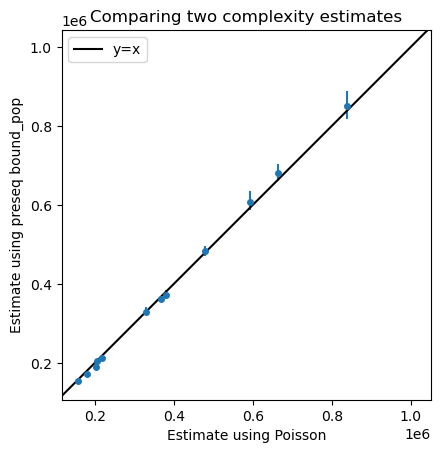

In [65]:
fig, ax = plt.subplots()
ax.errorbar(
    complexity_umi_all,
    df_preseq_estimates['median_estimated_unobs'],
    yerr=df_preseq_estimates[['lower_err', 'upper_err']].values.T,
    linestyle='',
    marker='.',
    markersize=8
)
ax.axline((1e6, 1e6), slope=1, c='black', label='y=x')
ax.set(
    xlabel='Estimate using Poisson',
    ylabel='Estimate using preseq bound_pop',
    title='Comparing two complexity estimates'
)
ax.axis('square')
ax.legend()
fig.show()

### Plot

In [66]:
df_data = df_data.merge(
    pd.concat(
        (
            complexity_umi_top.rename('complexity_umi_est_top'),
            complexity_umi_all.rename('complexity_umi_est_all'),
            complexity_umi_all2.rename('complexity_umi_est_all2'),
            df_barcode_counts_all.groupby('sample')['count_dedup'].sum()
        ),
        axis=1,
    ).reset_index(),
    how='left'
)

/tmp/ipykernel_176379/1703825926.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/tmp/ipykernel_176379/262201336.py:13: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



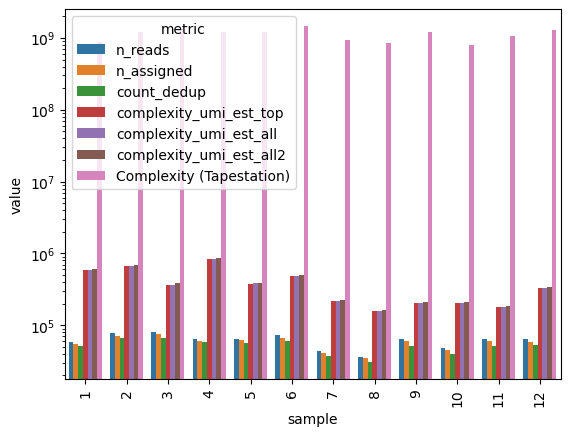

In [67]:
ax = sns.barplot(
    (
        df_data
        [['sample', 'n_reads', 'n_assigned', 'count_dedup', 'complexity_umi_est_top', 'complexity_umi_est_all', 'complexity_umi_est_all2', 'Complexity (Tapestation)']]
        .drop_duplicates()
        .melt(id_vars='sample')
        .rename(columns={'variable': 'metric'})
    ),
    x='sample',
    y='value',
    hue='metric'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yscale('log')
ax.figure.show()

### Estimates of total library complexity

Estimate from count numbers from pooling all samples

In [68]:
'{:g}'.format(estimate_library_complexity(df_barcode_counts_all['count'].sum(), df_barcode_counts_all['count_dedup'].sum()))

'3.83097e+06'

Sum of estimate of each sample - probably more accurate, since each sample likely had slightly different duplication rates as a result of less-than-perfectly-even pooling and different amplification rates for each sample.

In [69]:
'{:g}'.format(complexity_umi_all.sum())

'4.61569e+06'

Note that these 2 values above only count reads for which barcodes were identified.

Estimate from Qubit values
- 21.3 nM * 20 uL = pooled library
  - This represents 3.3/20 of total, since I only pooled 3.3 uL out of 20 uL from each of the 12 samples
- Account for 7 cycles of PCR
- Assume no loss upon gel cut

In [70]:
complexity_qubit = 21.3e-9 * 20e-6 * 20/3.3 / 2**7 * 6.022e23
'{:g}'.format(complexity_qubit)

'1.21466e+10'

Compare with estimated amount of oligo that went into PCR

In [71]:
'{:g}'.format(0.05e-12 * 12 * 6.022e23)

'3.6132e+11'

**The reason why complexity estimated by Tapestation is ~3 orders of magnitude higher than estimated by sequencing duplicates is due to the fact that the true complexity (close to what is actually estimated by Tapestation) far outstrips the UMI space, by ~3 orders of magnitude.** Consequently, the UMIs can at most represent a maximal complexity 3 orders of magnitude smaller than the true complexity,

In [72]:
complexity_qubit / umi_complexity

723.9966229958969

## Estimated coverage and duplication rate

"Coverage" = proportion of unique molecules that were sequenced and assigned.

In [73]:
df_barcode_counts_all['count_dedup'].sum() / complexity_qubit

5.120565064247991e-05

Duplication rate = proportion of sequenced and assigned reads that are duplicates

In [74]:
(
    df_barcode_counts_all[['sample', 'count', 'count_dedup']]
    .groupby(['sample']).sum()
    .pipe(lambda df: df.assign(duplication_rate=(df['count'] - df['count_dedup'])/df['count']))
)

/tmp/ipykernel_176379/720978626.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



count  count_dedup  duplication_rate
sample                                      
1       53817        51451          0.043964
2       69176        65691          0.050379
3       74238        67211          0.094655
4       59943        57848          0.034950
5       61065        56423          0.076017
6       65436        61157          0.065392
7       40419        36912          0.086766
8       33995        30587          0.100250
9       58906        51118          0.132211
10      44418        39931          0.101018
11      59727        50832          0.148928
12      57558        52816          0.082386

# Compare with exact matching

## Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [barcode + UMI]
  - format: n/a
  - `id_vars`: `sample`, `R5`, `R5_2`, `R6`, `R6_2`, `R7`, `R7_2`, `R8`, `R8_2`, `umi`, `umi_2`
  - `value_vars`: `count`
- `df_barcode_counts`: counts per barcode
  - format: wide
  - `id_vars`: `sample`, `R5`, `R6`, `R7`, `R8`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: deduplicated counts per tag
  - format: long
  - `id_vars`: `sample`, `count_type`, `round`, `tag`
  - `value_vars`: `count`

In [75]:
path_umi_validation_exact = os.path.join(DIR_RESULTS, 'umi_validation_exact.csv')
path_tag_counts_exact = os.path.join(DIR_RESULTS, 'tag_counts_exact.csv')
path_barcode_counts_exact = os.path.join(DIR_RESULTS, 'barcode_counts_exact.csv')
path_umi_ecdf_exact = os.path.join(DIR_RESULTS, 'umi_ecdf_exact.csv')

In [76]:
reprocess = reprocess or not all(os.path.exists(path) for path in [path_umi_validation_exact, path_tag_counts_exact, path_barcode_counts_exact, path_umi_ecdf_exact])
print('reprocess:', reprocess)

reprocess: True


In [77]:
if reprocess:
    df_umi_val_all_exact = {}
    df_umi_ecdf_exact = {}
    df_barcode_counts_all_exact = {}

In [78]:
if reprocess:
    for sample in df_data['sample'].unique():
        path_barcodes = os.path.join(DIR_PROC, f'read_barcodes_exact-{sample}.txt.gz')
        df_barcode_counts, df_umi_counts, n_unmatched, unmatched = count_barcodes(sample, regex_barcode, path_barcodes)
        if n_unmatched > 0:
            print((
                f'Sample {sample}: {n_unmatched} reads had barcodes [+ UMIs] that did not match '
                f'the regex. {min(3, n_unmatched)} / {n_unmatched} unmatched barcode-appended '
                'read names are printed below:'))
            for i in range(min(3, n_unmatched)):
                print('-', unmatched[i])
        df_umi_val_all_exact[sample] = (
            umi_df_to_validation(df_umi_counts, n_unmatched)
            .assign(sample=sample)
            .astype(dict(sample=DTYPE_SAMPLE))
        )
        df_umi_ecdf_exact[sample] = df_umi_counts['count'].value_counts()
        df_barcode_counts_all_exact[sample] = df_barcode_counts.assign(sample=sample).astype(dict(sample=DTYPE_SAMPLE))

### Save / Load Processed Data

In [79]:
if reprocess:
    df_umi_val_all_exact = pd.concat(df_umi_val_all_exact.values(), axis=0, ignore_index=True)
    df_umi_val_all_exact.to_csv(path_umi_validation_exact, index=False)
else:
    df_umi_val_all_exact = pd.read_csv(path_umi_validation_exact, index_col=False)

In [80]:
if reprocess:
    df_barcode_counts_all_exact = pd.concat(df_barcode_counts_all_exact.values(), axis=0, ignore_index=True)
    df_barcode_counts_all_exact.to_csv(path_barcode_counts_exact, index=False)
else:
    df_barcode_counts_all_exact = pd.read_csv(
        path_barcode_counts_exact,
        dtype={
            'R5': np.uint8,
            'R6': np.uint8,
            'R7': np.uint8,
            'R8': np.uint8,
            'count': np.int64,
            'count_dedup': np.int64,
            'sample': DTYPE_SAMPLE,
        },
        index_col=False
    )

In [81]:
if reprocess:
    df_umi_ecdf_long_exact = (
        pd.concat((pd.concat((pd.Series(0), s)) for s in df_umi_ecdf_exact.values()), axis=1)
        .fillna(0)
        .astype(int)
        .sort_index()
        .reset_index(names='count')
        .melt(id_vars='count', var_name='sample', value_name='frequency')
        .groupby('sample', group_keys=False)
        .apply(lambda g: (
            g.sort_values('count')
            .pipe(lambda g2: g.assign(cumulative_prop=g['frequency'].cumsum() / g['frequency'].sum()))
        ))
        .pipe(lambda df: df.assign(sample=df['sample'].map(lambda i: list(df_umi_ecdf_exact.keys())[i])))
    )
    df_umi_ecdf_long_exact.to_csv(path_umi_ecdf_exact, index=False)
else:
    df_umi_ecdf_long_exact = pd.read_csv(path_umi_ecdf_exact, index_col=False, dtype={'sample': DTYPE_SAMPLE})

/tmp/ipykernel_176379/315732705.py:10: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [82]:
if reprocess:
    df_tag_counts_exact = (
        df_barcode_counts_all_exact
        .rename(columns=dict(count='raw', count_dedup='dedup'))
        .melt(
            id_vars=ROUNDS + ['sample'],
            var_name='count_type',
            value_name='count'
        )
        .melt(
            id_vars=['sample', 'count_type', 'count'],
            value_vars=ROUNDS,
            var_name='round',
            value_name='tag'
        )
        .groupby(['sample', 'count_type', 'round', 'tag'], observed=True)
        ['count'].sum()
        .reset_index()
        .astype(dict(round=DTYPE_ROUNDS))
    )
    df_tag_counts_exact.to_csv(path_tag_counts_exact, index=False)
else:
    df_tag_counts_exact = pd.read_csv(
        path_tag_counts_exact,
        index_col=False,
        dtype=dict(
            sample=DTYPE_SAMPLE,
            count_type=DTYPE_COUNT_TYPE,
            round=DTYPE_ROUNDS,
            tag=np.uint8
        )
    )

## Validation

All assigned reads had read structures and UMIs matching expected regex.

In [83]:
df_umi_val_all_exact.loc[df_umi_val_all_exact['metric'] == 'n_unmatched', 'count'].unique()

array([0])

A negligible proportion of reads have different tags identified in read 1 vs. read 2, but there was a more sizeable proportion (up to ~2.5%) of reads with different UMIs identified in read 1 vs. read 2.

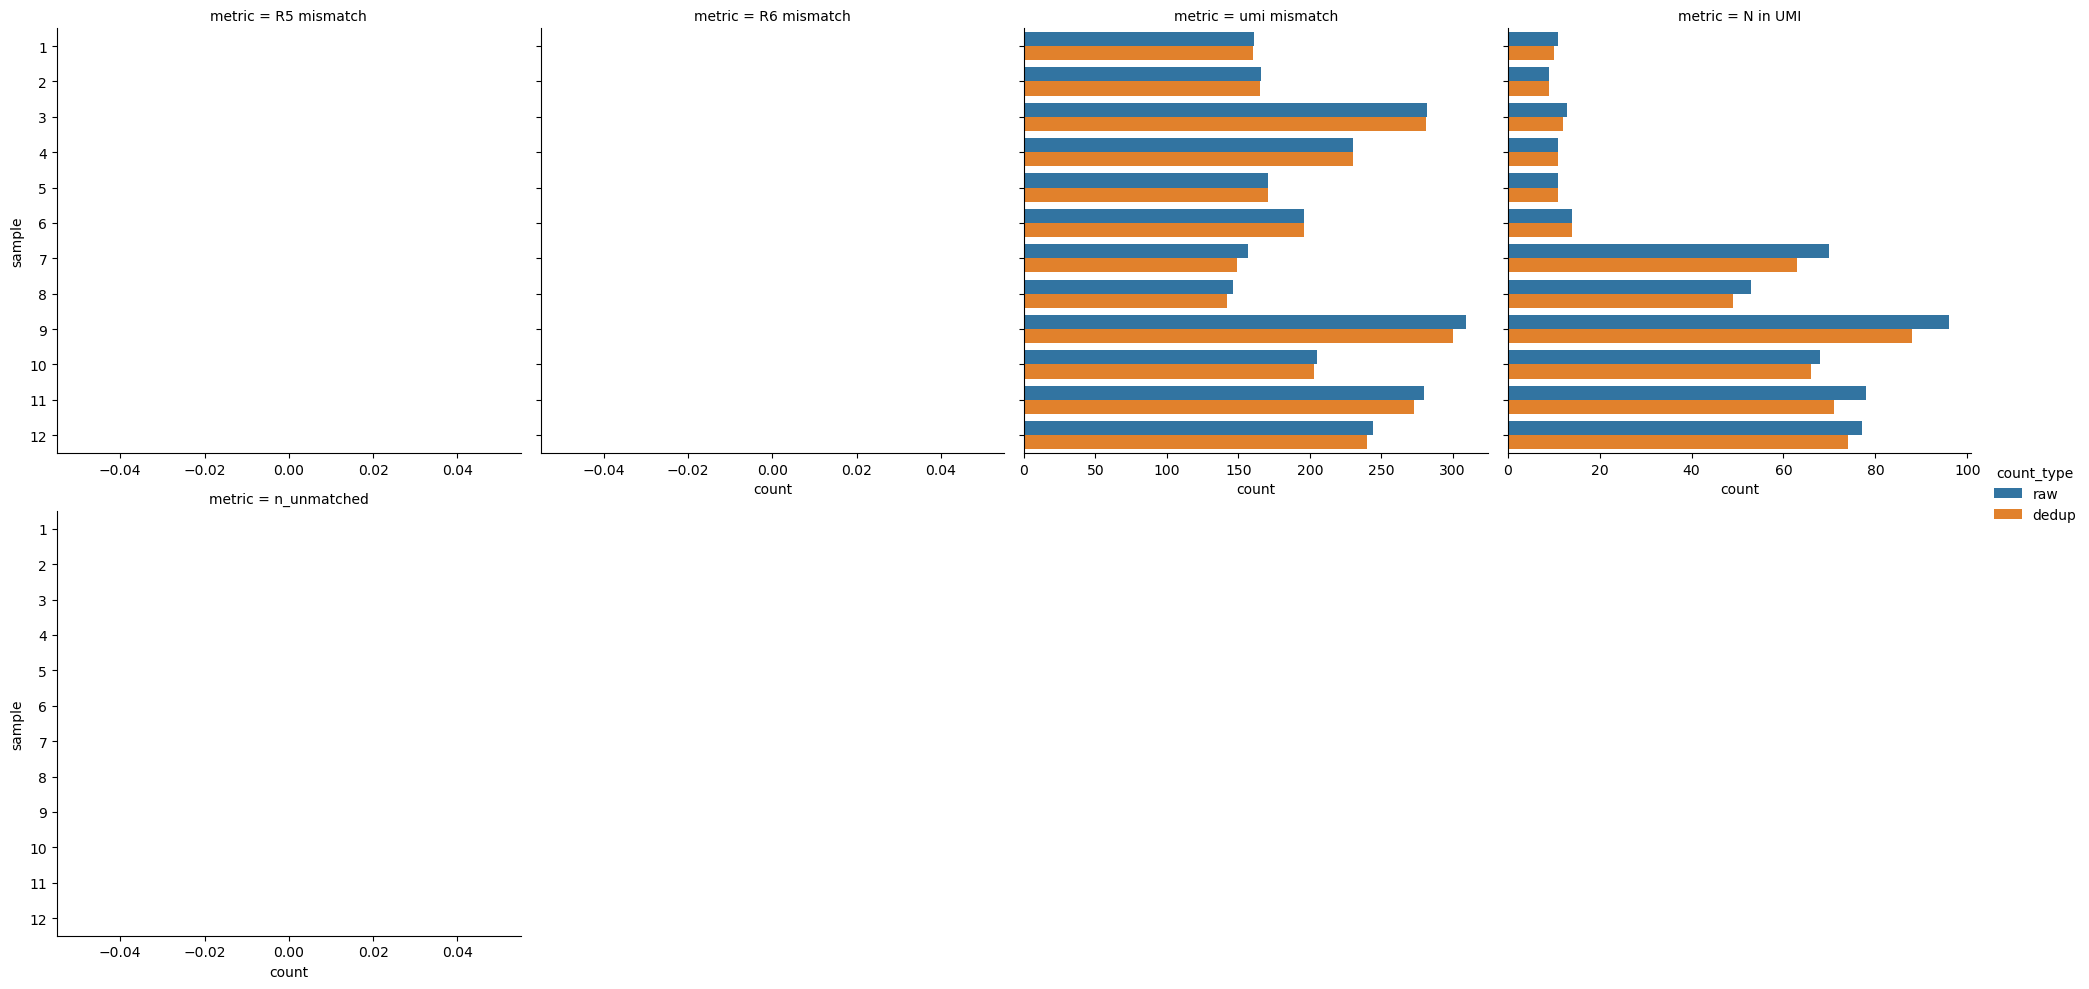

In [84]:
g = sns.catplot(
    kind='bar',
    data=df_umi_val_all_exact,
    x='count',
    y='sample',
    hue='count_type',
    col='metric',
    col_wrap=4,
    sharex=False
)

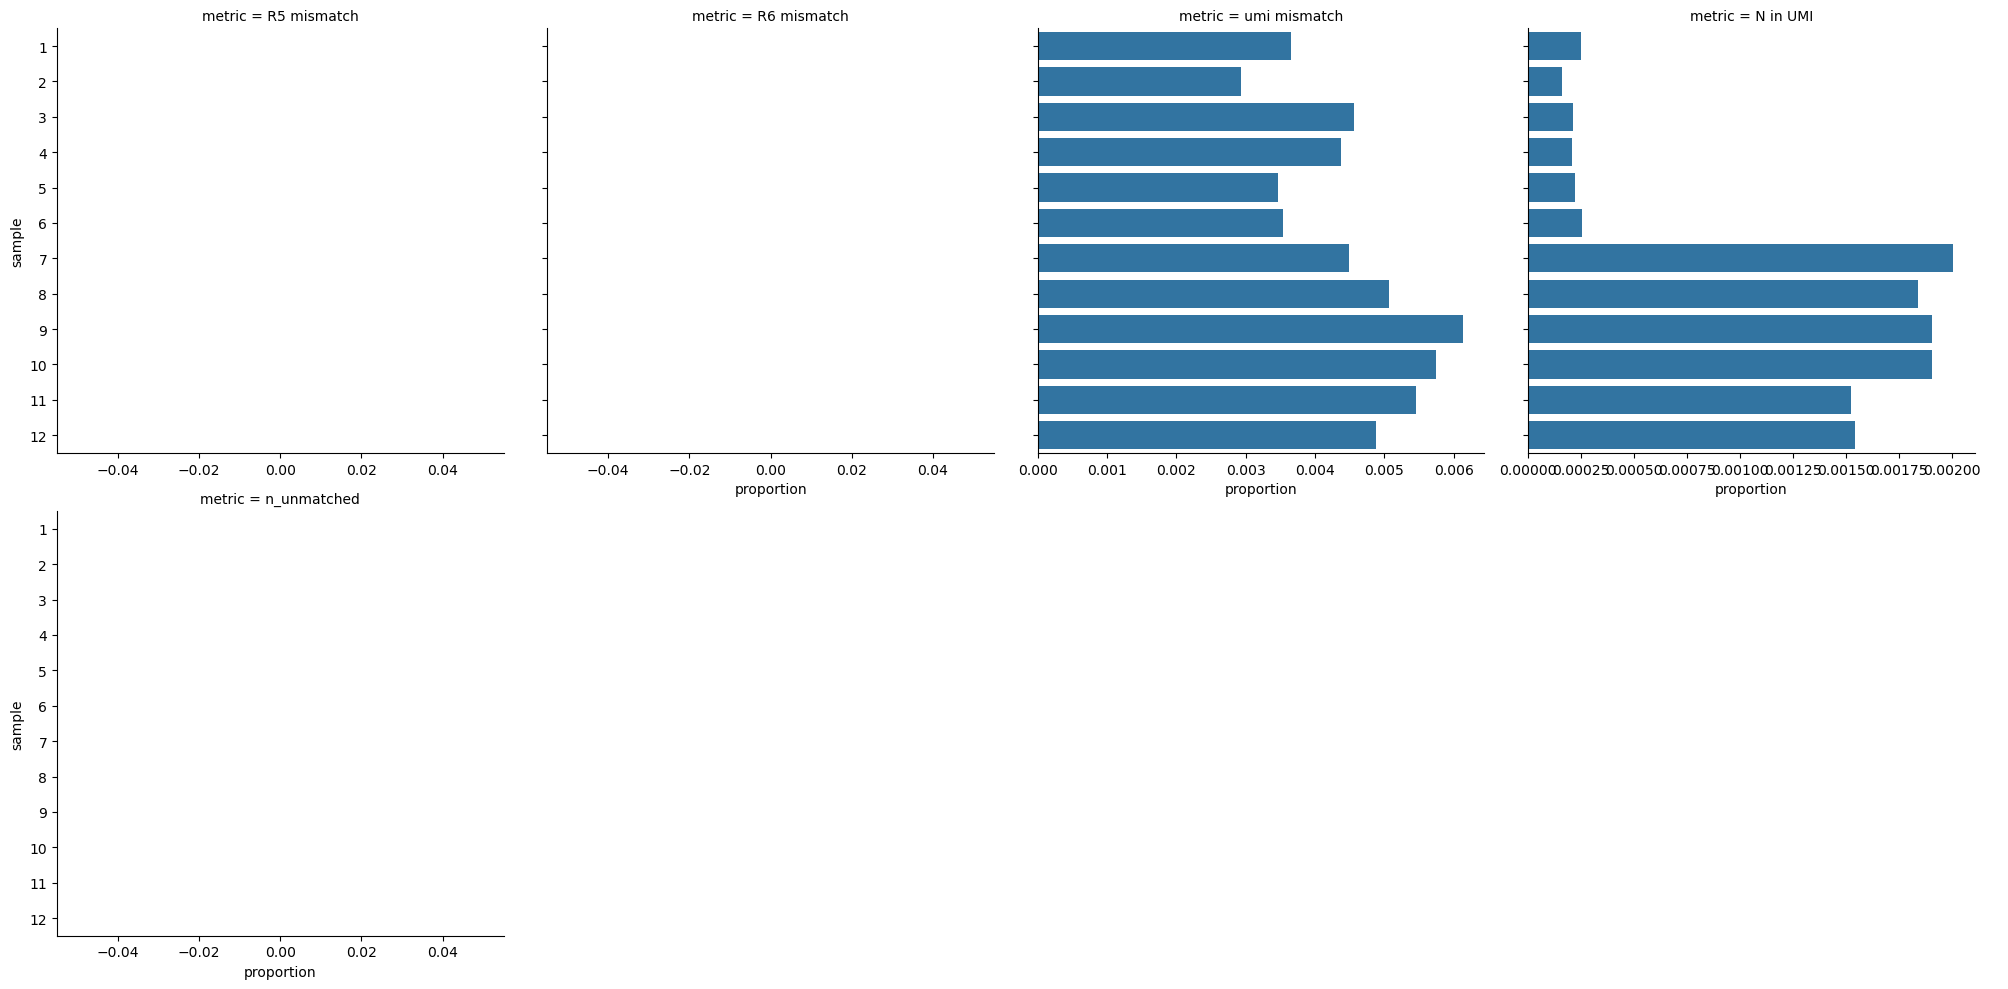

In [85]:
g = sns.catplot(
    kind='bar',
    data=(
        df_umi_val_all_exact
        .loc[df_umi_val_all_exact['count_type'] == 'raw']
        .drop(columns='count_type')
        .merge(df_data[['sample', 'n_assigned_exact']].drop_duplicates('sample'))
        .pipe(lambda df: df.assign(proportion=df['count'] / df['n_assigned_exact']))
        [['metric', 'sample', 'proportion']]
        .astype({'sample': 'category'})
    ),
    x='proportion',
    y='sample',
    col='metric',
    col_wrap=4,
    color='C0',
    sharex=False
)

## Ligation QC

Tag counts faceted by sample and round, grouped (colored) by count type (raw or deduplicated)

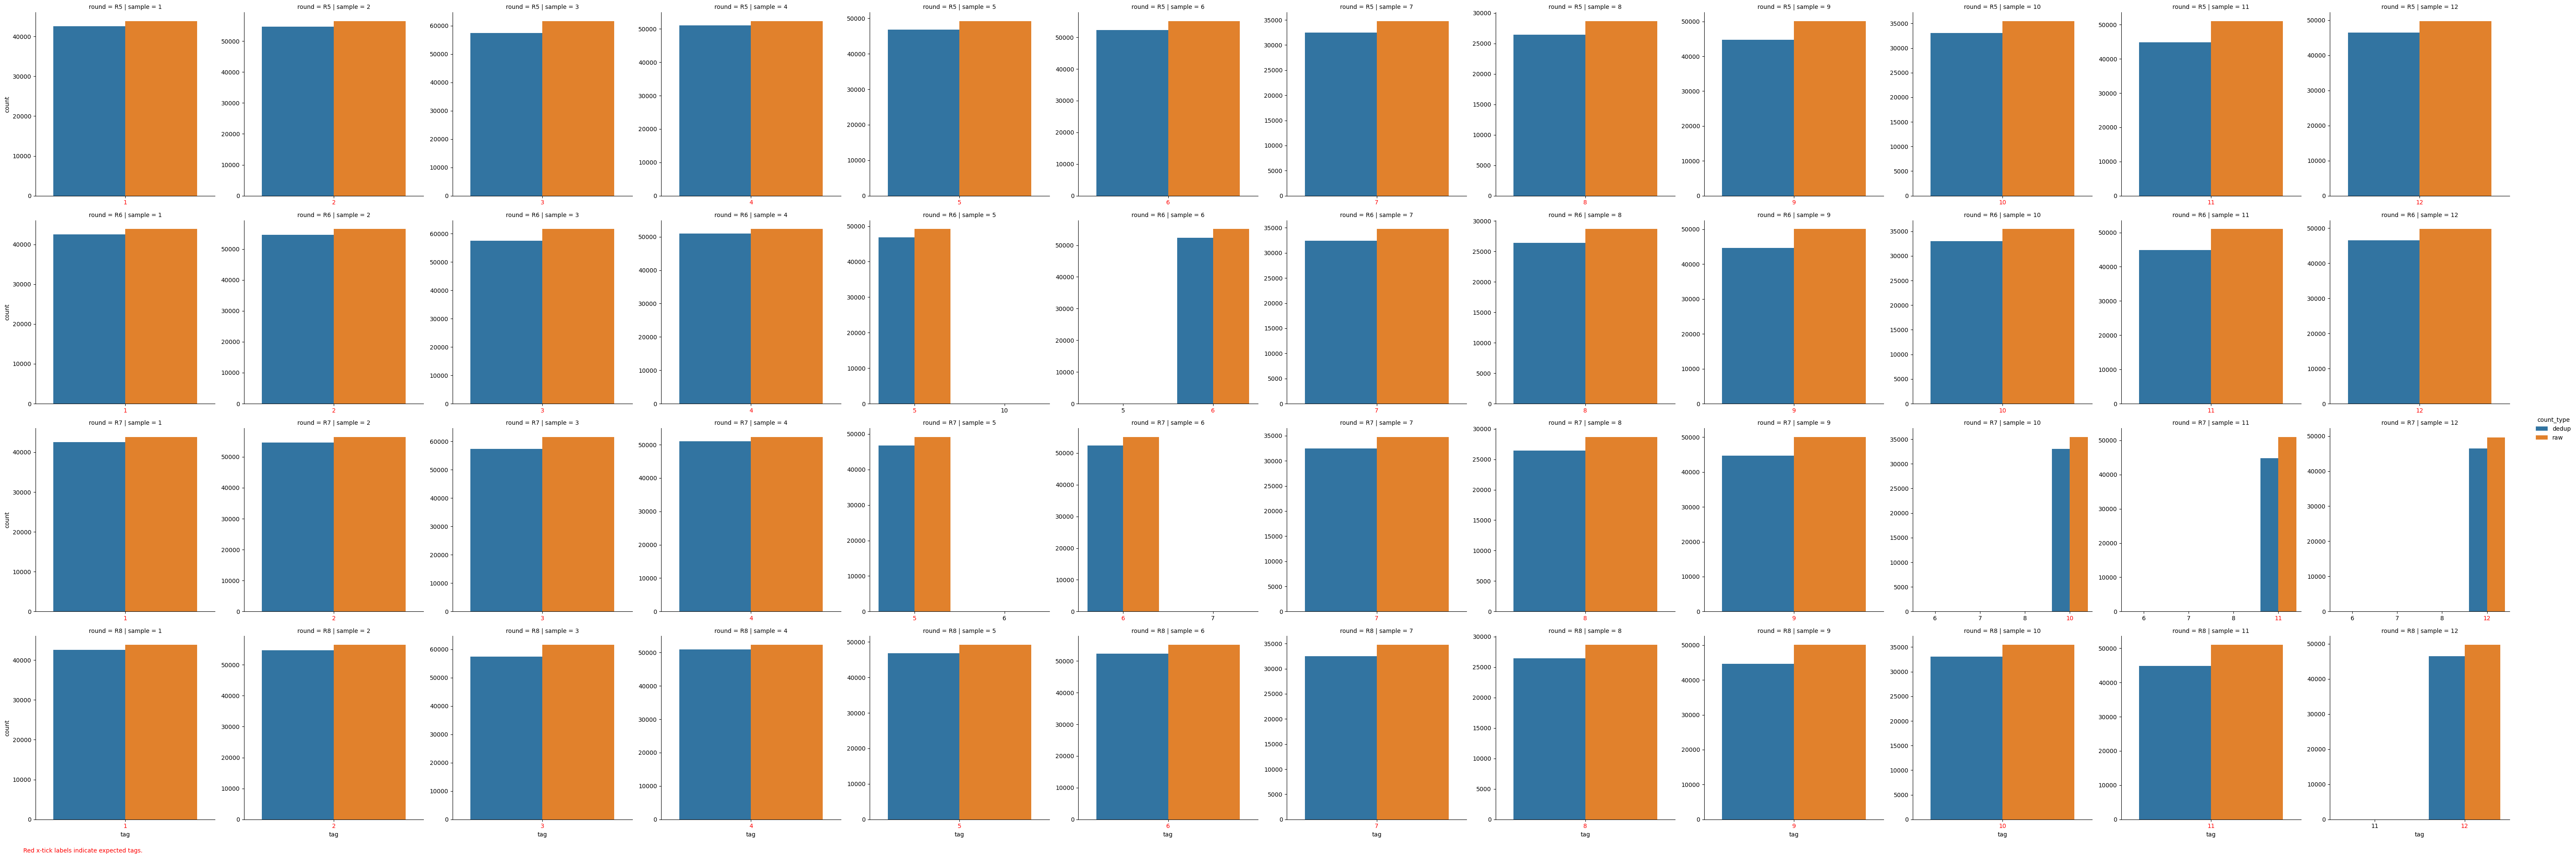

In [86]:
g = sns.catplot(
    df_tag_counts_exact,
    kind='bar',
    x='tag',
    y='count',
    row='round',
    row_order=ROUNDS,
    hue='count_type',
    col='sample',
    sharex=False,
    sharey='col'
)

# red color for xticklabels corresponding to expected tag
for (r, sample), ax in g.axes_dict.items():
    for text in ax.get_xticklabels():
        if int(text.get_text()) == sample:
            text.set_color('red')
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

g.figure.text(
    0.01,
    -0.01,
    'Red x-tick labels indicate expected tags.',
    color='red',
    ha='left'
)

g.figure.savefig(
    os.path.join(DIR_RESULTS, 'tag_counts_by_sample_exact.pdf'),
    bbox_inches='tight',
    dpi=300
)

Flow diagram (Sankey / parallel categories plot)

In [87]:
for sample in df_barcode_counts_all_exact['sample'].unique():
    mask_sample = (df_barcode_counts_all_exact['sample'] == sample)
    fig = go.Figure(go.Parcats(
        dimensions=[
            {
                'label': r,
                'values': df_barcode_counts_all_exact.loc[mask_sample, r],
                'categoryorder': 'category ascending'
            } for r in ROUNDS
        ],
        counts=df_barcode_counts_all_exact.loc[mask_sample, 'count_dedup']))
    fig.update_layout(
        title_text=f'Sample: {sample}',
        width=600,
        height=600,
        margin=dict(l=10, b=10, t=50, r=10)
    )
    # fig.show()
    fig.write_image(os.path.join(DIR_RESULTS, f'parcats_exact_{sample}.pdf'))

Count (or proportion of total count) per barcode (akin to scSPRITE Figure 1C)

In [88]:
fig = px.line(
    (
        df_barcode_counts_all
        .groupby('sample', group_keys=False)
        .apply(lambda g:
           g.assign(
               rank=np.argsort(np.argsort(-g['count_dedup'])),
               proportion=g['count_dedup'] / g['count_dedup'].sum()
           ).pipe(lambda g2: g2.loc[g2['rank'] < 6]))
        .reset_index()
        .melt(id_vars=['sample', 'rank'], value_vars=['count', 'proportion'], var_name='metric')
        .sort_values(['sample', 'rank'])
    ),
    x='rank',
    y='value',
    color='sample',
    facet_row='metric',
    markers=True,
    category_orders=dict(sample=sorted(df_data['sample'].unique())),
    color_discrete_sequence=sns.color_palette('cividis', n_colors=len(df_data['sample'].unique())).as_hex(),
    labels={'rank': 'barcode rank'}
)
fig.update_yaxes(
    matches=None,
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_xaxes(
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_layout(
    margin=dict(l=0, b=10, t=50, r=10),
    height=600,
    width=800,
    plot_bgcolor='#fff'
)
fig.write_image(os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank.png'), scale=2)
fig.show()

/tmp/ipykernel_176379/1000479752.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_176379/1000479752.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/home/btyeh/miniconda3/envs/py3/lib/python3.11/site-packages/plotly/express/_core.py:1971: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [89]:
fig = px.line(
    (
        df_barcode_counts_all_exact
        .groupby('sample', group_keys=False)
        .apply(lambda g:
           g.assign(
               rank=np.argsort(np.argsort(-g['count_dedup'])),
               proportion=g['count_dedup'] / g['count_dedup'].sum()
           ).pipe(lambda g2: g2.loc[g2['rank'] < 6]))
        .reset_index()
        .melt(id_vars=['sample', 'rank'], value_vars=['count', 'proportion'], var_name='metric')
        .sort_values(['sample', 'rank'])
    ),
    x='rank',
    y='value',
    color='sample',
    facet_row='metric',
    markers=True,
    category_orders=dict(sample=sorted(df_data['sample'].unique())),
    color_discrete_sequence=sns.color_palette('cividis', n_colors=len(df_data['sample'].unique())).as_hex(),
    labels={'rank': 'barcode rank'}
)
fig.update_yaxes(
    matches=None,
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_xaxes(
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_layout(
    margin=dict(l=0, b=10, t=50, r=10),
    height=600,
    width=800,
    plot_bgcolor='#fff'
)
fig.write_image(os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank_exact.png'), scale=2)
fig.show()

/tmp/ipykernel_176379/3100511398.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_176379/3100511398.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/home/btyeh/miniconda3/envs/py3/lib/python3.11/site-packages/plotly/express/_core.py:1971: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Sequencing Depth and Duplicates

### UMI distribution

In [90]:
umi_distribution_exact = (
    df_umi_ecdf_long_exact.groupby('count')['frequency'].sum()
    .pipe(lambda s: s/s.sum()).rename('proportion')
)
display(umi_distribution_exact)
print('mean UMI count: {:.3f}'.format((np.array(umi_distribution_exact.index) * umi_distribution_exact).sum()))

count
0    0.000000
1    0.935405
2    0.062779
3    0.001793
4    0.000022
Name: proportion, dtype: float64

mean UMI count: 1.066


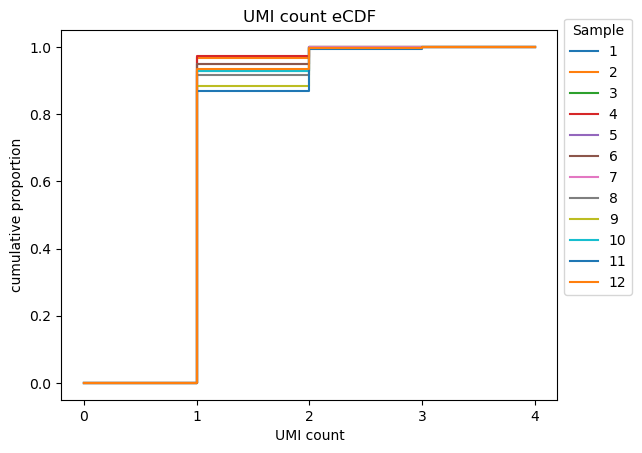

In [91]:
fig, ax = plt.subplots()
for sample in sorted(df_umi_ecdf_long_exact['sample'].unique()):
    mask = (df_umi_ecdf_long_exact['sample'] == sample)
    ax.step(
        df_umi_ecdf_long_exact.loc[mask, 'count'],
        df_umi_ecdf_long_exact.loc[mask, 'cumulative_prop'],
        where='post',
        label=sample
    )
ax.legend(title='Sample', loc='upper left', bbox_to_anchor=(1, 1.05))
ax.set(xlabel='UMI count', ylabel='cumulative proportion', title='UMI count eCDF', xticks=range(df_umi_ecdf_long_exact['count'].max() + 1))
fig.show()

### Estimate library complexity

Calculate the complexity of all barcodes in each sample.

In [92]:
complexity_umi_all_exact = df_barcode_counts_all_exact.groupby('sample')[['count', 'count_dedup']].sum().apply(
    lambda s: estimate_library_complexity(s['count'], s['count_dedup']),
    axis=1)

/tmp/ipykernel_176379/1735663721.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Calculate the complexity of the predominant barcode in each sample.

In [93]:
complexity_umi_top_exact = (
    df_barcode_counts_all_exact
    .groupby("sample", group_keys=True)
    .apply(lambda group: group.iloc[group["count"].argmax()][["count", "count_dedup"]])
    .apply(lambda s: estimate_library_complexity(s['count'], s['count_dedup']), axis=1)
)

/tmp/ipykernel_176379/3315055852.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_176379/3315055852.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



#### Plot

In [94]:
df_data = df_data.merge(
    pd.concat(
        (
            complexity_umi_top_exact.rename('complexity_umi_est_top_exact'),
            complexity_umi_all_exact.rename('complexity_umi_est_all_exact'),
            df_barcode_counts_all_exact.groupby('sample')['count_dedup'].sum().rename('count_dedup_exact')
        ),
        axis=1,
    ).reset_index(),
    how='left'
)

/tmp/ipykernel_176379/1350778008.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



/tmp/ipykernel_176379/4289334315.py:13: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



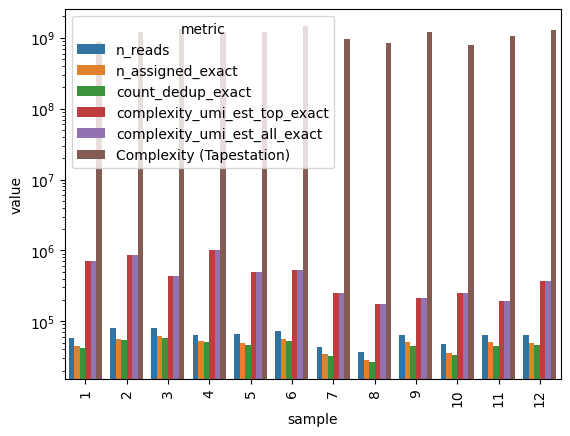

In [95]:
ax = sns.barplot(
    (
        df_data
        [['sample', 'n_reads', 'n_assigned_exact', 'count_dedup_exact', 'complexity_umi_est_top_exact', 'complexity_umi_est_all_exact', 'Complexity (Tapestation)']]
        .drop_duplicates()
        .melt(id_vars='sample')
        .rename(columns={'variable': 'metric'})
    ),
    x='sample',
    y='value',
    hue='metric'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yscale('log')
ax.figure.show()

#### Estimates of total library complexity

Estimate from count numbers from pooling all samples

In [96]:
'{:g}'.format(estimate_library_complexity(df_barcode_counts_all_exact['count'].sum(), df_barcode_counts_all_exact['count_dedup'].sum()))

'4.35421e+06'

Sum of estimate of each sample - probably more accurate, since each sample likely had slightly different duplication rates as a result of less-than-perfectly-even pooling and different amplification rates for each sample.

In [97]:
'{:g}'.format(complexity_umi_all_exact.sum())

'5.49954e+06'

Note that these 2 values above only count reads for which barcodes were identified.

### Estimated coverage and duplication rate

"Coverage" = proportion of unique molecules that were sequenced and assigned.

In [98]:
df_barcode_counts_all_exact['count_dedup'].sum() / complexity_qubit

4.386115510732945e-05

Duplication rate = proportion of sequenced and assigned reads that are duplicates

In [99]:
(
    df_barcode_counts_all_exact[['sample', 'count', 'count_dedup']]
    .groupby(['sample']).sum()
    .pipe(lambda df: df.assign(duplication_rate=(df['count'] - df['count_dedup'])/df['count']))
)

/tmp/ipykernel_176379/1041599051.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



count  count_dedup  duplication_rate
sample                                      
1       43847        42536          0.029899
2       56459        54645          0.032130
3       61607        57455          0.067395
4       52327        50997          0.025417
5       49199        46834          0.048070
6       55106        52359          0.049849
7       34760        32451          0.066427
8       28676        26431          0.078288
9       50078        44678          0.107832
10      35465        33032          0.068603
11      51024        44844          0.121119
12      49741        46504          0.065077